<a href="https://colab.research.google.com/github/MehrdadJalali-AI/BlackHole/blob/main/Results_Evaluation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

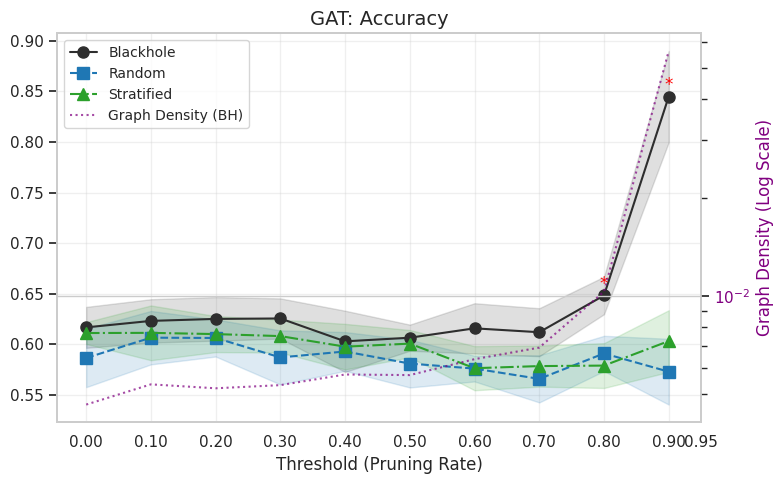

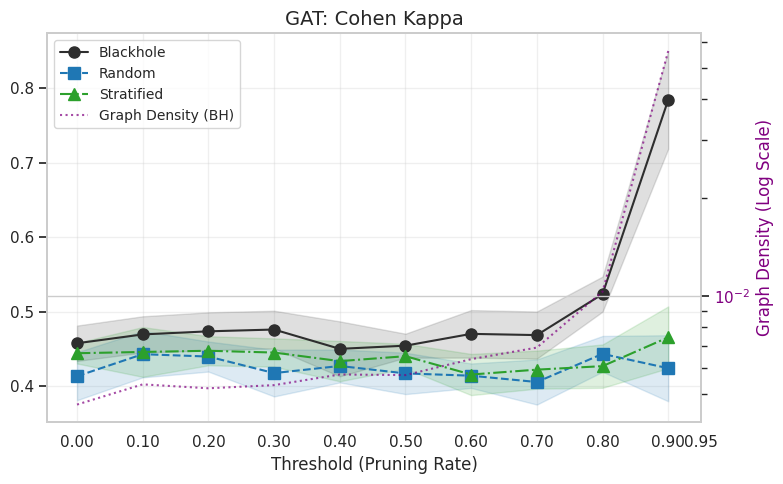

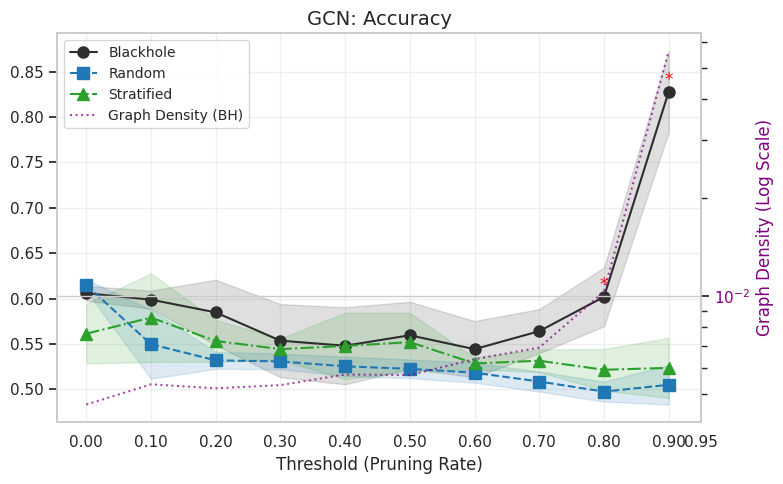

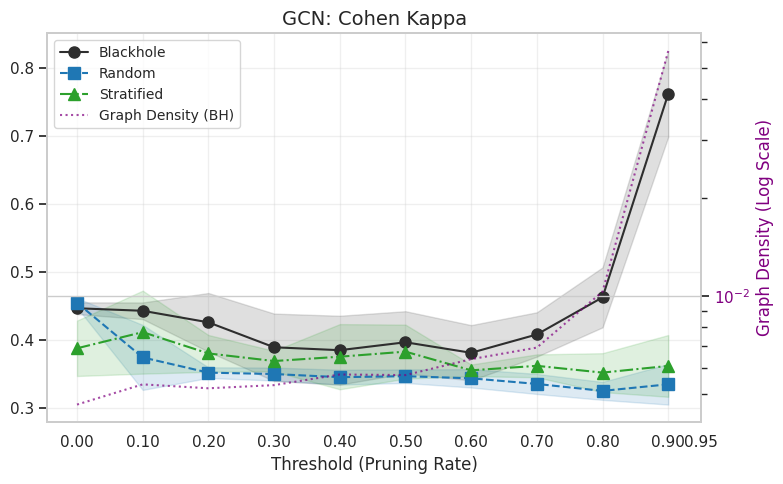

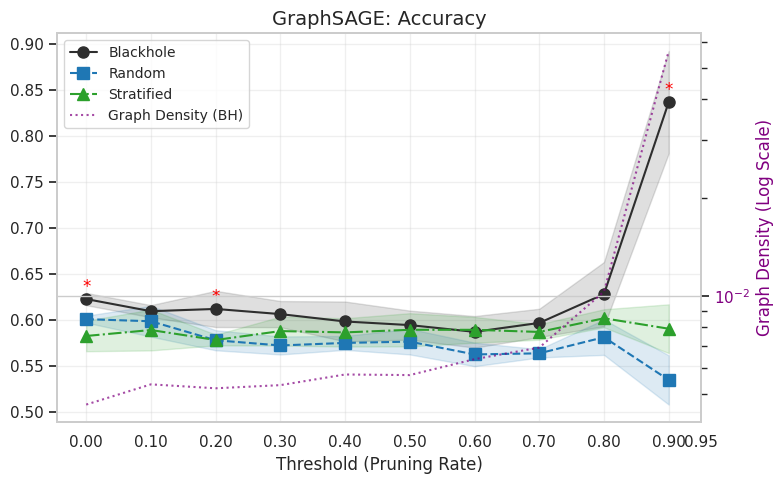

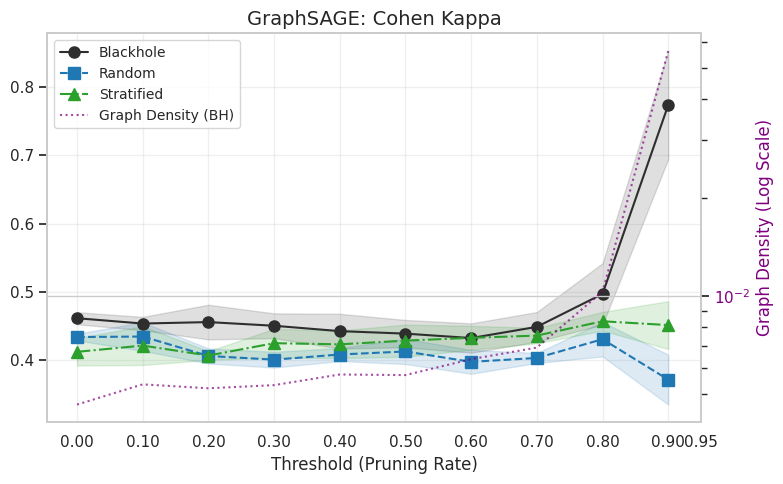

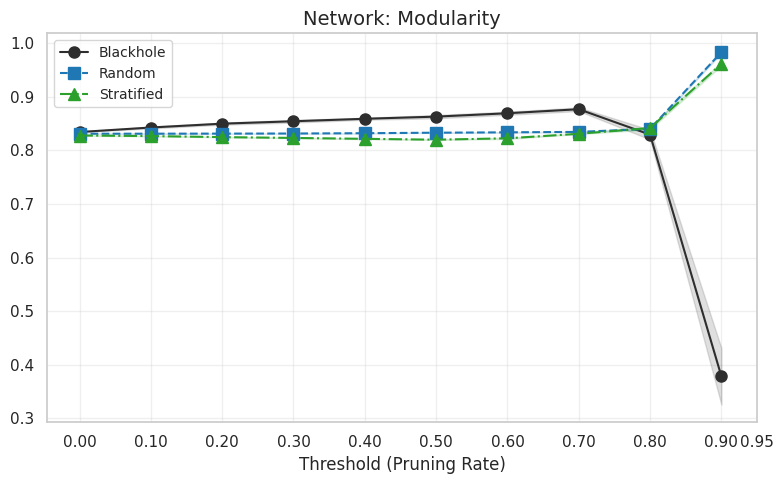

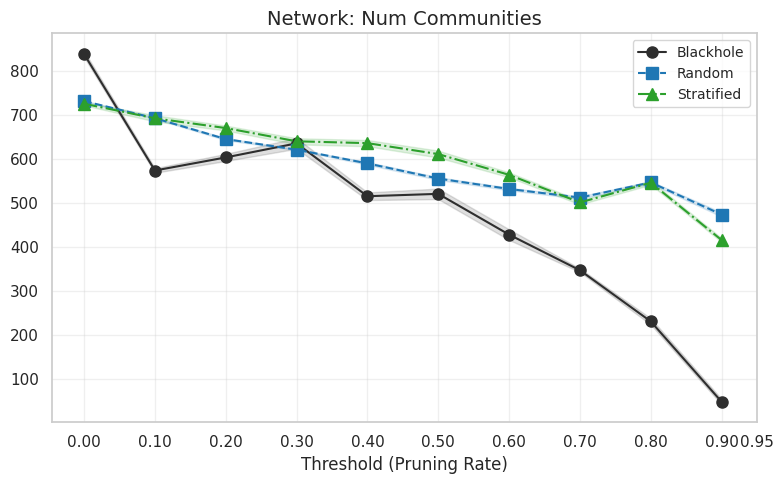

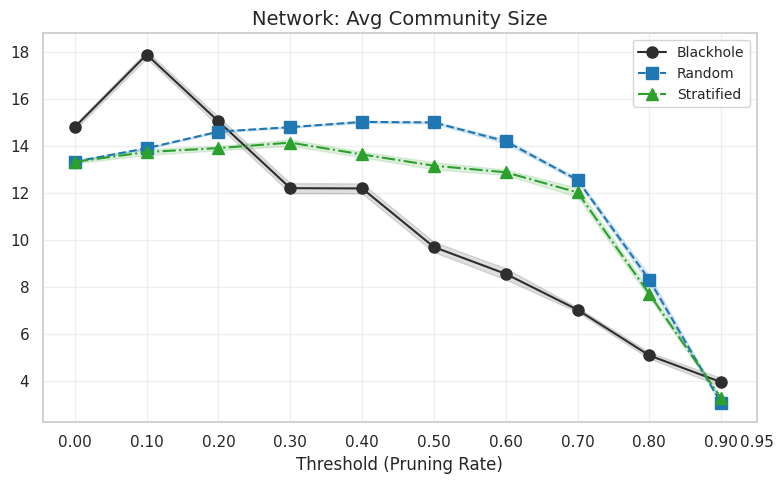

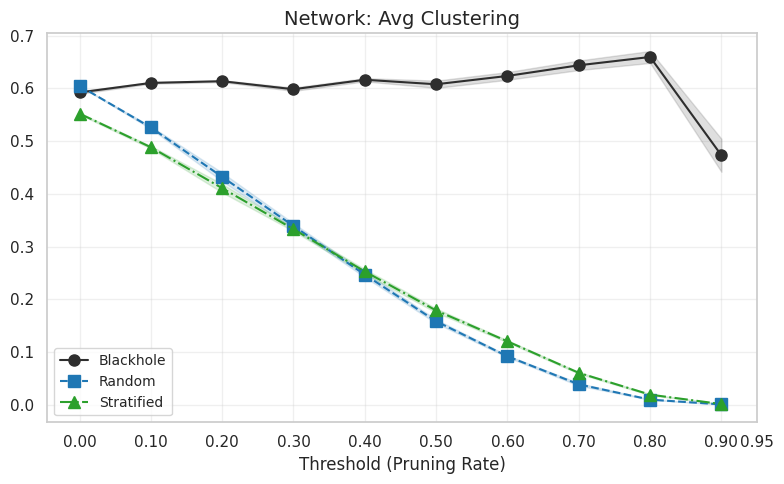

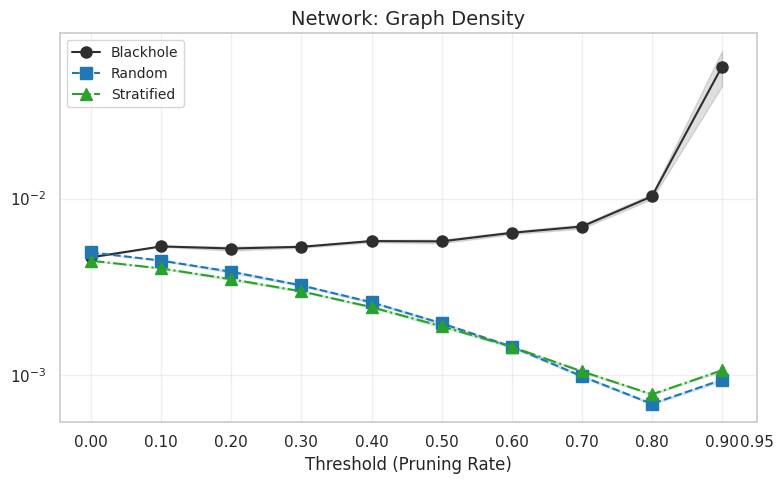

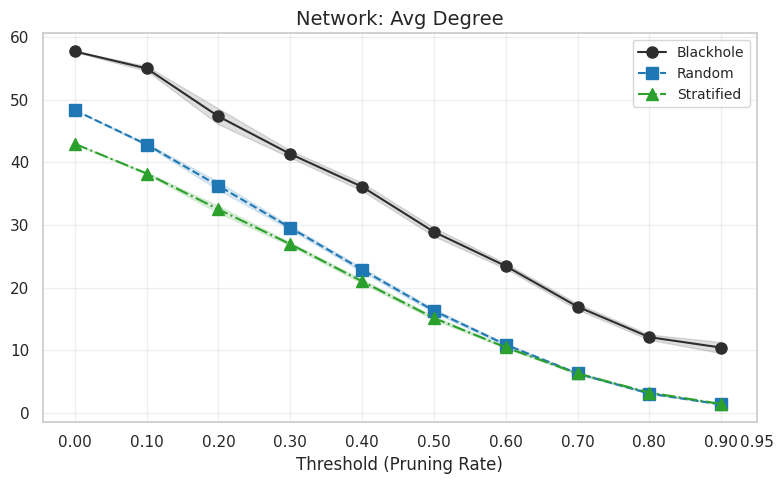

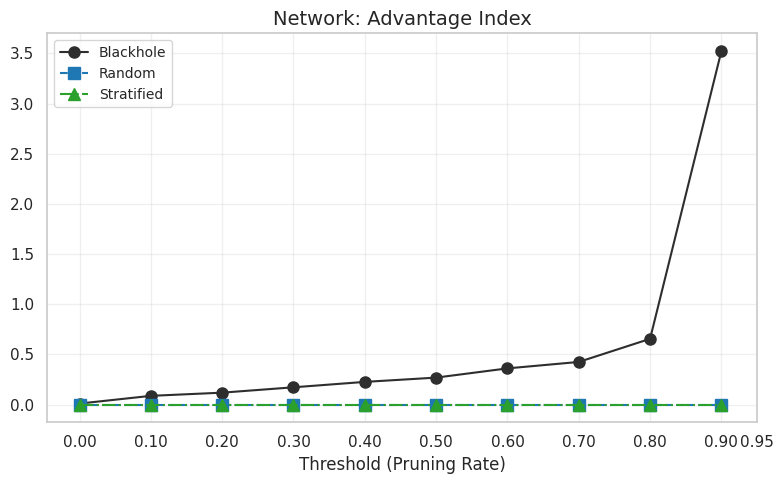

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_Mean                     Accuracy_SEM            \
Model                          GAT       GCN GraphSAGE          GAT       GCN   
Threshold Method                                                                
0.0       blackhole       0.616810  0.605857  0.623093     0.020216  0.008111   
          random          0.586585  0.615003  0.601229     0.028866  0.006161   
          stratified      0.611210  0.561254  0.582951     0.010795  0.032761   
0.1       blackhole       0.623202  0.598816  0.609882     0.021422  0.009883   
          random          0.606629  0.549728  0.598947     0.026398  0.038009   
          stratified      0.611395  0.579029  0.589433     0.027050  0.048768   
0.2       blackhole       0.625176  0.584768  0.612344     0.021579  0.035995   
          random          0.606340  0.531954  0.578310     0.018342  0.009300   
          stratified      0.610170  0.553331  0.578579

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

output_dir = 'plots_Comparison'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/aggregated_results_v2.csv')

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    # Baseline values at threshold 0.0 for normalization
    baseline = df[df['Threshold'] == 0.0].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_Mean': 0.4, 'Modularity_Mean': 0.3, 'Graph_Density_Mean': 0.3}
    df['Advantage_Index'] = 0.0

    for thresh in df['Threshold'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Threshold'] == thresh) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                rand_data = subset[subset['Method'] == 'random']
                strat_data = subset[subset['Method'] == 'stratified']

                if not (bh_data.empty or rand_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    rand_vals = rand_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_rand = baseline.loc['random', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]

                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        rand_val = rand_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        base_rand_val = base_rand[metric]
                        base_strat_val = base_strat[metric]

                        # Normalize differences
                        norm_bh_rand = (bh_val - rand_val) / base_bh_val if base_bh_val != 0 else (bh_val - rand_val)
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        # Average normalized advantage
                        metric_advantage = (norm_bh_rand + norm_bh_strat) / 2
                        advantage += weights[metric] * metric_advantage

                    df.loc[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_SEM'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_SEM')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std'),
    ('Advantage_Index', None)  # No SEM for derived index
]

# Models and thresholds
models = df['Model'].unique()
threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# Filter dataframe to only include specified thresholds
df = df[df['Threshold'].isin(threshold_values)]

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'random', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        if std_metric:
            ax.fill_between(method_data['Threshold'],
                            method_data[metric] - method_data[std_metric],
                            method_data[metric] + method_data[std_metric],
                            alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_Mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for thresh in threshold_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
            rand_data = subset[(subset['Method'] == 'random') & (subset['Threshold'] == thresh)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Threshold'] == thresh)]
            if not (bh_data.empty or rand_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
                rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
                if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
                   is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Threshold (Pruning Rate)', fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save and show plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            rand_acc = rand_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, thresh, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, thresh, model, bh_acc, strat_acc))

# Find maximum and minimum distances
max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_SEM', 'Cohen_Kappa_Mean', 'Cohen_Kappa_SEM'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((thresh, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for thresh, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Threshold {thresh:.2f}, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Threshold {max_dist_bh_random[1]:.2f}, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Threshold {min_dist_bh_random[1]:.2f}, Model {min_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Threshold {max_dist_bh_stratified[1]:.2f}, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Threshold {min_dist_bh_stratified[1]:.2f}, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_Mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_Mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.2f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_Mean']:.6f}, "
      f"Advantage Index = {max_acc_row['Advantage_Index']:.4f}")


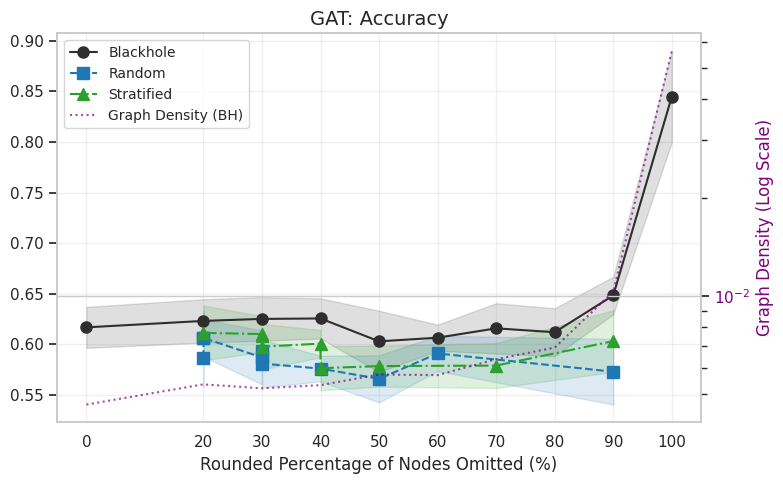

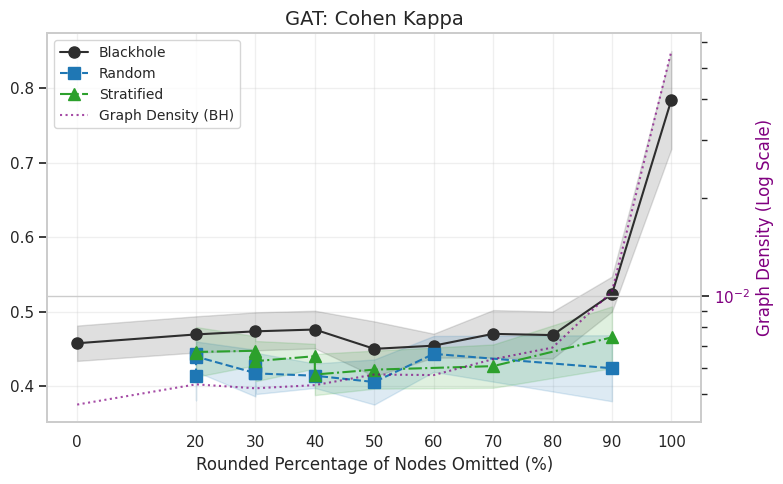

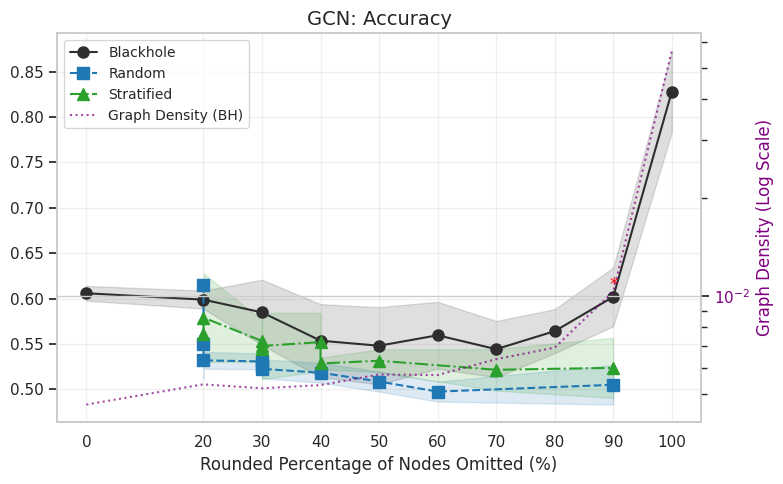

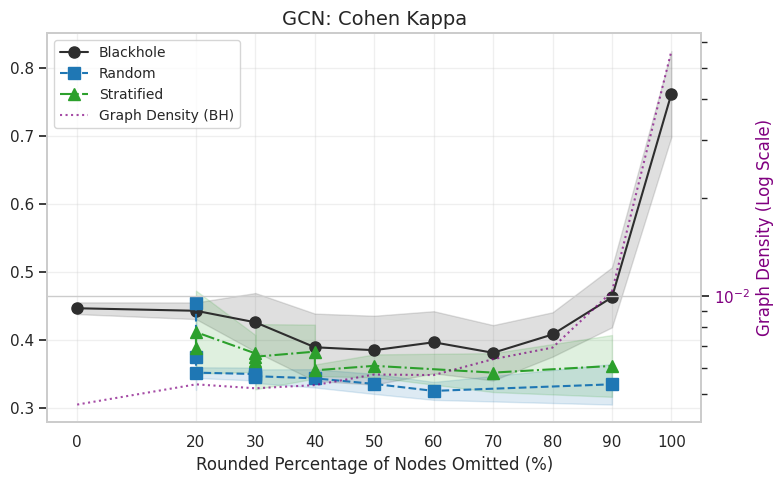

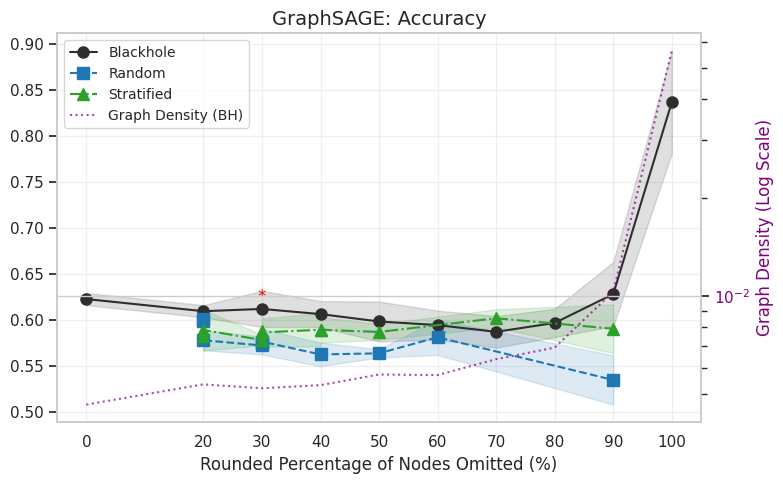

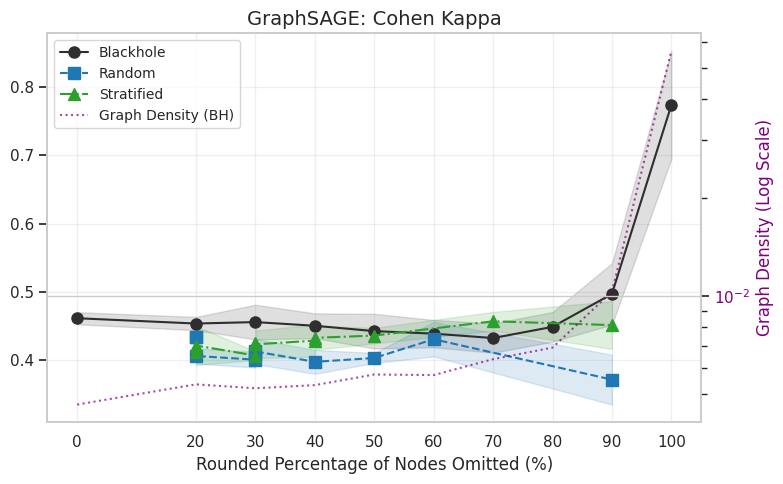

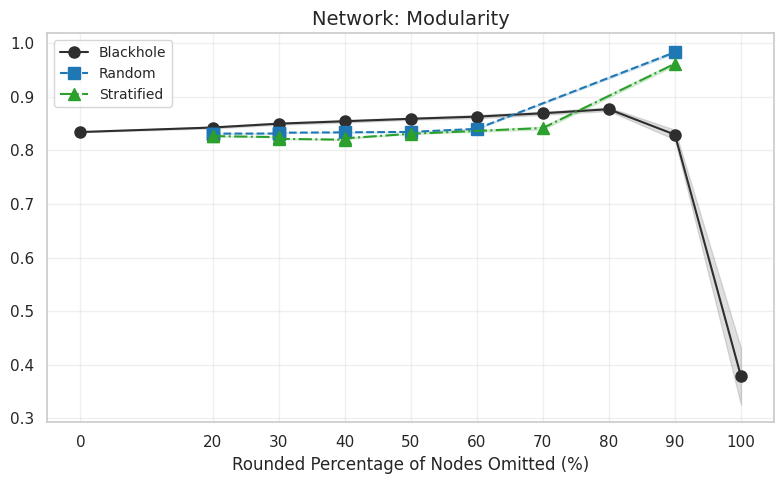

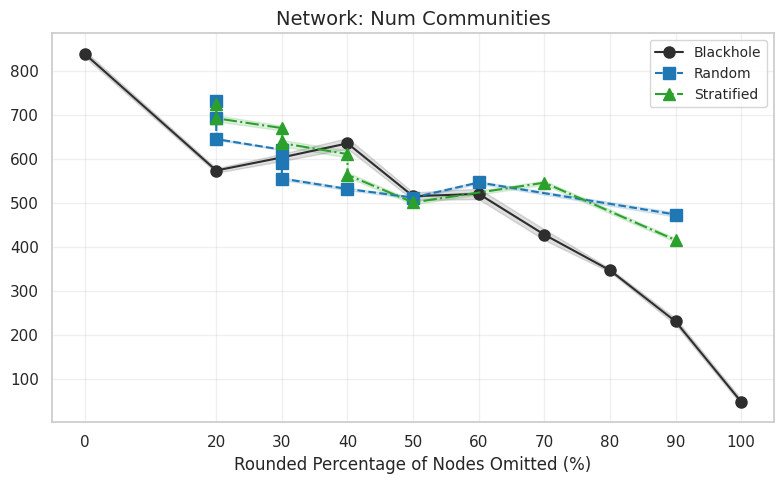

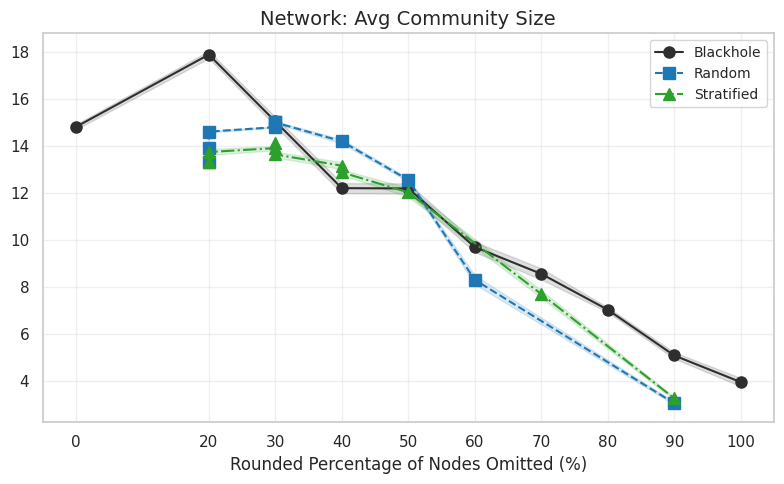

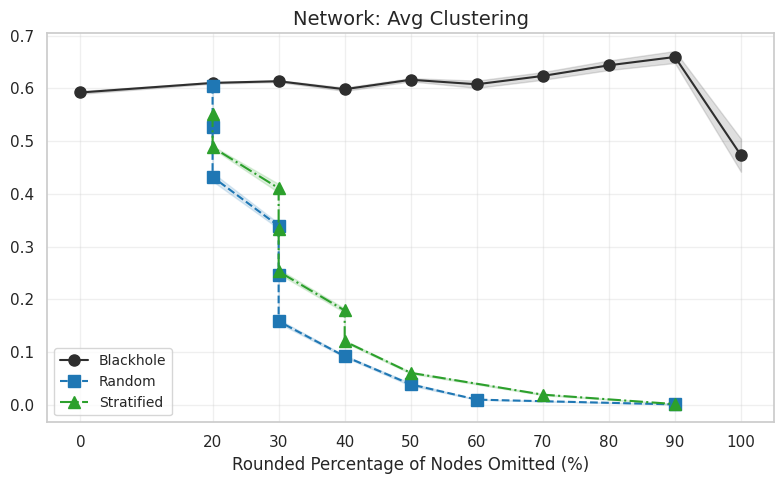

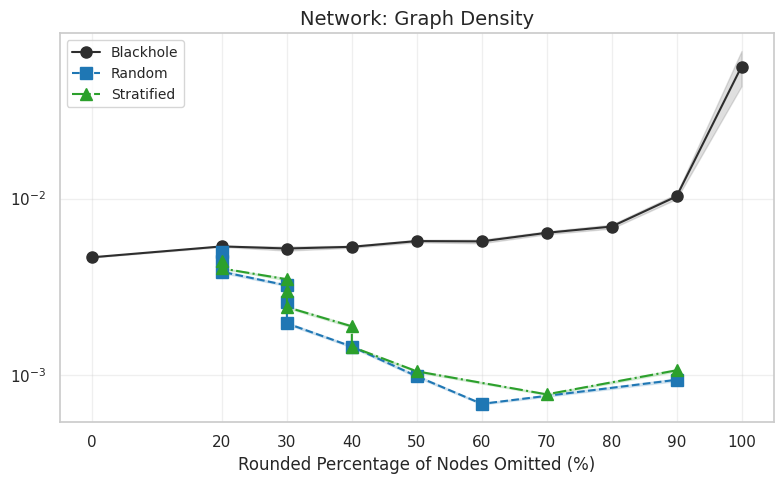

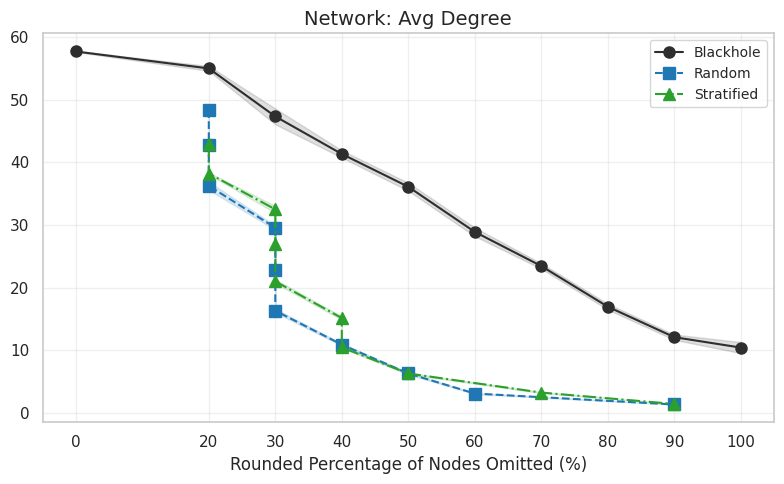

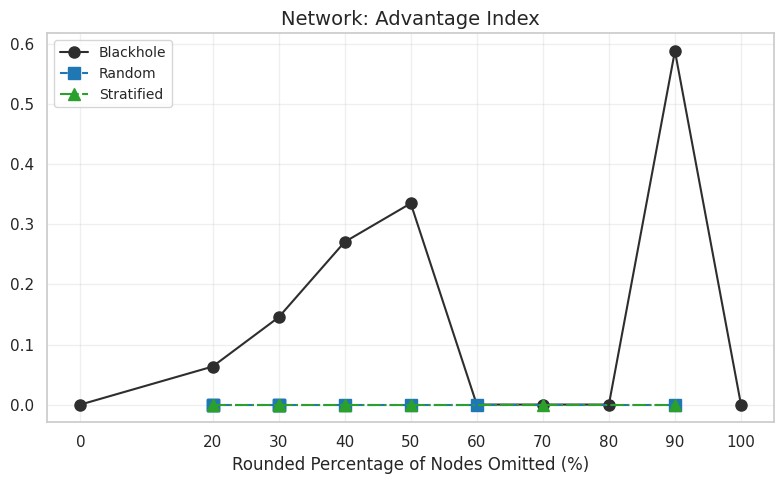

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                                         Accuracy_Mean                      \
Model                                              GAT       GCN GraphSAGE   
Rounded_Percent_Nodes_Omitted Method                                         
0.0                           blackhole       0.616810  0.605857  0.623093   
20.0                          blackhole       0.623202  0.598816  0.609882   
                              random          0.586585  0.615003  0.601229   
                              stratified      0.611210  0.561254  0.582951   
30.0                          blackhole       0.625176  0.584768  0.612344   
                              random          0.587094  0.530752  0.572644   
                              stratified      0.610170  0.553331  0.578579   
40.0                          blackhole       0.625602  0.553624  0.606735   
                              random          0.576074  0.518335  0.562893   
         

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

output_dir = 'plots_Comparison'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/aggregated_results_v2.csv')

# Calculate percentage of nodes omitted and round to nearest 10%
df['Rounded_Percent_Nodes_Omitted'] = np.round((100 - df['Percent_Nodes_Retained_Mean']) / 10) * 10

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    # Baseline values at min Rounded_Percent_Nodes_Omitted (max retention) for normalization
    min_percent = df['Rounded_Percent_Nodes_Omitted'].min()
    baseline = df[df['Rounded_Percent_Nodes_Omitted'] == min_percent].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_Mean': 0.4, 'Modularity_Mean': 0.3, 'Graph_Density_Mean': 0.3}
    df['Advantage_Index'] = 0.0

    # Check available methods in baseline
    available_methods = baseline.index.tolist()
    required_methods = ['blackhole', 'random', 'stratified']
    missing_methods = [m for m in required_methods if m not in available_methods]
    if missing_methods:
        print(f"Warning: Methods {missing_methods} not found in baseline at Rounded_Percent_Nodes_Omitted = {min_percent}%. Using overall mean for these methods.")
        # Use overall mean for missing methods
        overall_means = df.groupby('Method').mean(numeric_only=True)
        for method in missing_methods:
            baseline.loc[method] = overall_means.loc[method]

    for percent in df['Rounded_Percent_Nodes_Omitted'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                rand_data = subset[subset['Method'] == 'random']
                strat_data = subset[subset['Method'] == 'stratified']

                if not (bh_data.empty or rand_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    rand_vals = rand_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_rand = baseline.loc['random', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]

                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        rand_val = rand_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        base_rand_val = base_rand[metric]
                        base_strat_val = base_strat[metric]

                        # Normalize differences
                        norm_bh_rand = (bh_val - rand_val) / base_bh_val if base_bh_val != 0 else (bh_val - rand_val)
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        # Average normalized advantage
                        metric_advantage = (norm_bh_rand + norm_bh_strat) / 2
                        advantage += weights[metric] * metric_advantage

                    df.loc[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_SEM'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_SEM')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std'),
    ('Advantage_Index', None)  # No SEM for derived index
]

# Models and rounded percent nodes omitted values
models = df['Model'].unique()
percent_values = sorted(df['Rounded_Percent_Nodes_Omitted'].unique())

# Filter dataframe to only include specified percent values
df = df[df['Rounded_Percent_Nodes_Omitted'].isin(percent_values)]

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'random', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Rounded_Percent_Nodes_Omitted')
        if not method_data.empty:
            ax.plot(method_data['Rounded_Percent_Nodes_Omitted'], method_data[metric],
                    label=f'{method.title()}',
                    color=method_colors[method], linestyle=method_styles[method],
                    marker=method_markers[method], markersize=8)
            if std_metric:
                ax.fill_between(method_data['Rounded_Percent_Nodes_Omitted'],
                                method_data[metric] - method_data[std_metric],
                                method_data[metric] + method_data[std_metric],
                                alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Rounded_Percent_Nodes_Omitted')
        if not density_data.empty:
            ax2.plot(density_data['Rounded_Percent_Nodes_Omitted'], density_data['Graph_Density_Mean'],
                     color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
            ax2.set_yscale('log')
            ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
            ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for percent in percent_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Rounded_Percent_Nodes_Omitted'] == percent)]
            rand_data = subset[(subset['Method'] == 'random') & (subset['Rounded_Percent_Nodes_Omitted'] == percent)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Rounded_Percent_Nodes_Omitted'] == percent)]
            if not (bh_data.empty or rand_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
                rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
                if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
                   is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(percent, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Rounded Percentage of Nodes Omitted (%)', fontsize=label_fontsize)
    ax.set_xticks(percent_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save and show plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for percent in percent_values:
    for model in models:
        bh_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            rand_acc = rand_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, percent, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, percent, model, bh_acc, strat_acc))

# Find maximum and minimum distances
if distances_bh_random:
    max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
    min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
else:
    max_dist_bh_random = (0, 0, 'N/A', 0, 0)
    min_dist_bh_random = (0, 0, 'N/A', 0, 0)
if distances_bh_stratified:
    max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
    min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])
else:
    max_dist_bh_stratified = (0, 0, 'N/A', 0, 0)
    min_dist_bh_stratified = (0, 0, 'N/A', 0, 0)

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Rounded_Percent_Nodes_Omitted', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_SEM', 'Cohen_Kappa_Mean', 'Cohen_Kappa_SEM'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Rounded_Percent_Nodes_Omitted', 'Method'],
    values=[metric for metric, _ in network_metrics if metric != 'Advantage_Index'] + ['Advantage_Index'],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for percent in percent_values:
    for model in models:
        bh_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Cohen_Kappa_SEM'].values[0] # FIX: Was Accuracy_SEM, should be Cohen_Kappa_SEM
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((percent, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Percentages where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for percent, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Rounded Percent Nodes Omitted {percent:.2f}%, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No percentages where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Rounded Percent Nodes Omitted {max_dist_bh_random[1]:.2f}%, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Rounded Percent Nodes Omitted {min_dist_bh_random[1]:.2f}%, Model {min_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Rounded Percent Nodes Omitted {max_dist_bh_stratified[1]:.2f}%, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Rounded Percent Nodes Omitted {min_dist_bh_stratified[1]:.2f}%, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_Mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_Mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Rounded Percent Nodes Omitted {max_acc_row['Rounded_Percent_Nodes_Omitted']:.2f}%, "
      f"with Graph Density = {max_acc_row['Graph_Density_Mean']:.6f}, "
      f"Advantage Index = {max_acc_row['Advantage_Index']:.4f}")
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

output_dir = 'plots_Comparison'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/aggregated_results_v2.csv')

# Calculate percentage of nodes omitted and round to nearest 10%
df['Rounded_Percent_Nodes_Omitted'] = np.round((100 - df['Percent_Nodes_Retained_Mean']) / 10) * 10

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    # Baseline values at min Rounded_Percent_Nodes_Omitted (max retention) for normalization
    min_percent = df['Rounded_Percent_Nodes_Omitted'].min()
    baseline = df[df['Rounded_Percent_Nodes_Omitted'] == min_percent].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_Mean': 0.4, 'Modularity_Mean': 0.3, 'Graph_Density_Mean': 0.3}
    df['Advantage_Index'] = 0.0

    # Check available methods in baseline
    available_methods = baseline.index.tolist()
    required_methods = ['blackhole', 'random', 'stratified']
    missing_methods = [m for m in required_methods if m not in available_methods]
    if missing_methods:
        print(f"Warning: Methods {missing_methods} not found in baseline at Rounded_Percent_Nodes_Omitted = {min_percent}%. Using overall mean for these methods.")
        # Use overall mean for missing methods
        overall_means = df.groupby('Method').mean(numeric_only=True)
        for method in missing_methods:
            baseline.loc[method] = overall_means.loc[method]

    for percent in df['Rounded_Percent_Nodes_Omitted'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                rand_data = subset[subset['Method'] == 'random']
                strat_data = subset[subset['Method'] == 'stratified']

                if not (bh_data.empty or rand_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    rand_vals = rand_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_rand = baseline.loc['random', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]

                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        rand_val = rand_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        base_rand_val = base_rand[metric]
                        base_strat_val = base_strat[metric]

                        # Normalize differences
                        norm_bh_rand = (bh_val - rand_val) / base_bh_val if base_bh_val != 0 else (bh_val - rand_val)
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        # Average normalized advantage
                        metric_advantage = (norm_bh_rand + norm_bh_strat) / 2
                        advantage += weights[metric] * metric_advantage

                    df.loc[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_SEM'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_SEM')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std'),
    ('Advantage_Index', None)  # No SEM for derived index
]

# Models and rounded percent nodes omitted values
models = df['Model'].unique()
percent_values = sorted(df['Rounded_Percent_Nodes_Omitted'].unique())

# Filter dataframe to only include specified percent values
df = df[df['Rounded_Percent_Nodes_Omitted'].isin(percent_values)]

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'random', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Rounded_Percent_Nodes_Omitted')
        if not method_data.empty:
            ax.plot(method_data['Rounded_Percent_Nodes_Omitted'], method_data[metric],
                    label=f'{method.title()}',
                    color=method_colors[method], linestyle=method_styles[method],
                    marker=method_markers[method], markersize=8)
            if std_metric:
                ax.fill_between(method_data['Rounded_Percent_Nodes_Omitted'],
                                method_data[metric] - method_data[std_metric],
                                method_data[metric] + method_data[std_metric],
                                alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Rounded_Percent_Nodes_Omitted')
        if not density_data.empty:
            ax2.plot(density_data['Rounded_Percent_Nodes_Omitted'], density_data['Graph_Density_Mean'],
                     color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
            ax2.set_yscale('log')
            ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
            ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for percent in percent_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Rounded_Percent_Nodes_Omitted'] == percent)]
            rand_data = subset[(subset['Method'] == 'random') & (subset['Rounded_Percent_Nodes_Omitted'] == percent)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Rounded_Percent_Nodes_Omitted'] == percent)]
            if not (bh_data.empty or rand_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
                rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
                if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
                   is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(percent, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Rounded Percentage of Nodes Omitted (%)', fontsize=label_fontsize)
    ax.set_xticks(percent_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save and show plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for percent in percent_values:
    for model in models:
        bh_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            rand_acc = rand_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, percent, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, percent, model, bh_acc, strat_acc))

# Find maximum and minimum distances
if distances_bh_random:
    max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
    min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
else:
    max_dist_bh_random = (0, 0, 'N/A', 0, 0)
    min_dist_bh_random = (0, 0, 'N/A', 0, 0)
if distances_bh_stratified:
    max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
    min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])
else:
    max_dist_bh_stratified = (0, 0, 'N/A', 0, 0)
    min_dist_bh_stratified = (0, 0, 'N/A', 0, 0)

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Rounded_Percent_Nodes_Omitted', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_SEM', 'Cohen_Kappa_Mean', 'Cohen_Kappa_SEM'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Rounded_Percent_Nodes_Omitted', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for percent in percent_values:
    for model in models:
        bh_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Rounded_Percent_Nodes_Omitted'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((percent, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Percentages where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for percent, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Rounded Percent Nodes Omitted {percent:.2f}%, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No percentages where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Rounded Percent Nodes Omitted {max_dist_bh_random[1]:.2f}%, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Rounded Percent Nodes Omitted {min_dist_bh_random[1]:.2f}%, Model {min_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Rounded Percent Nodes Omitted {max_dist_bh_stratified[1]:.2f}%, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Rounded Percent Nodes Omitted {min_dist_bh_stratified[1]:.2f}%, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_Mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_Mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Rounded Percent Nodes Omitted {max_acc_row['Rounded_Percent_Nodes_Omitted']:.2f}%, "
      f"with Graph Density = {max_acc_row['Graph_Density_Mean']:.6f}, "
      f"Advantage Index = {max_acc_row['Advantage_Index']:.4f}")
```

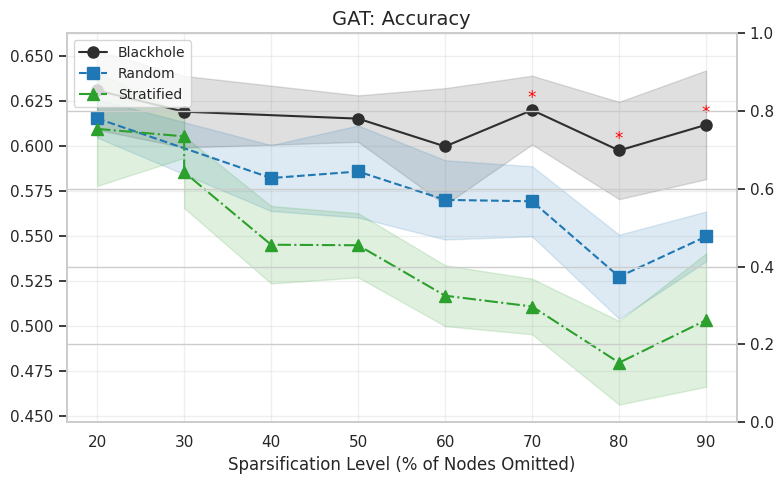

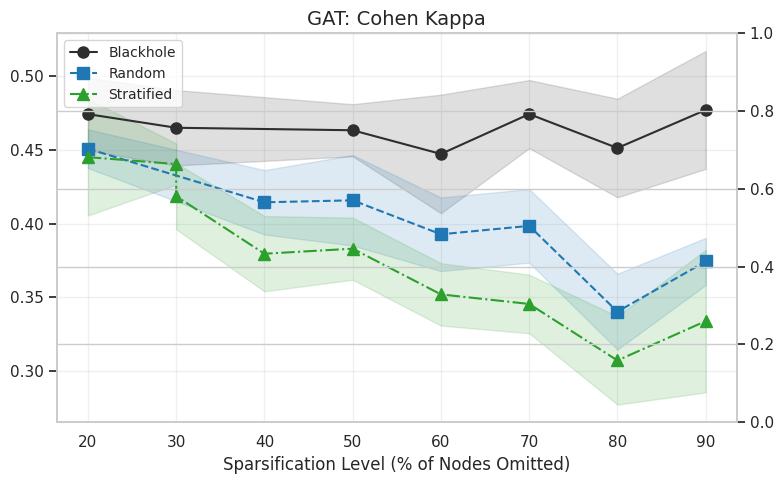

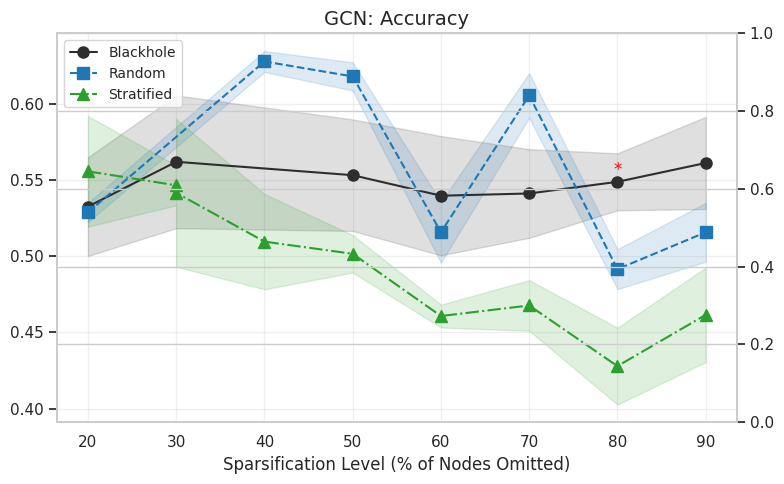

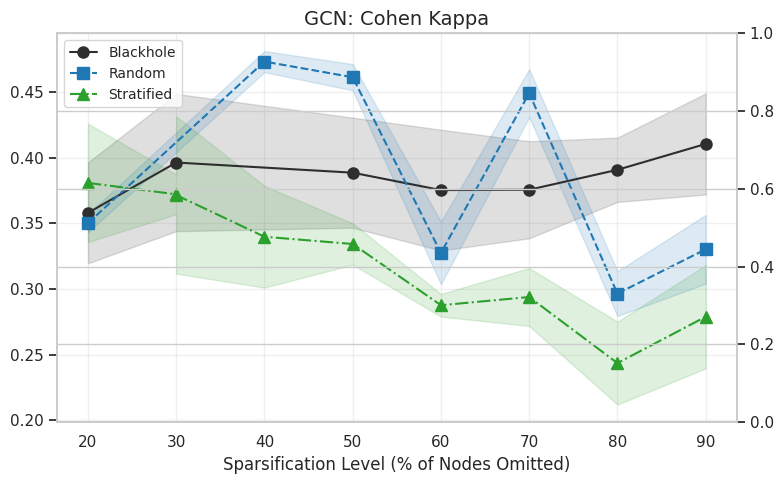

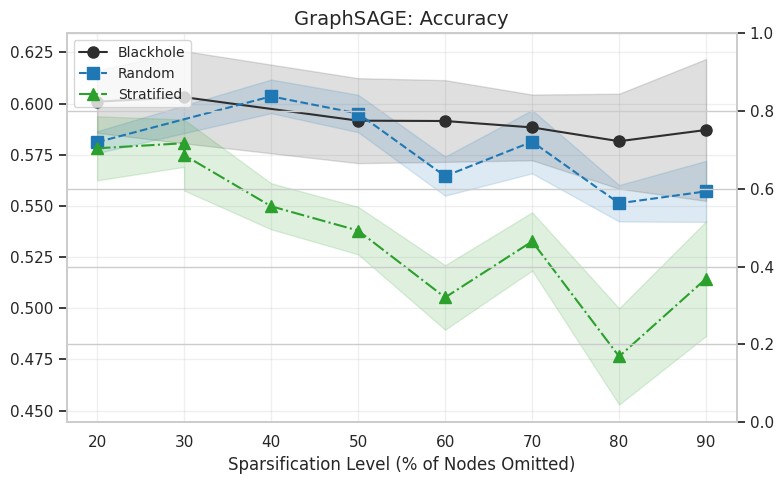

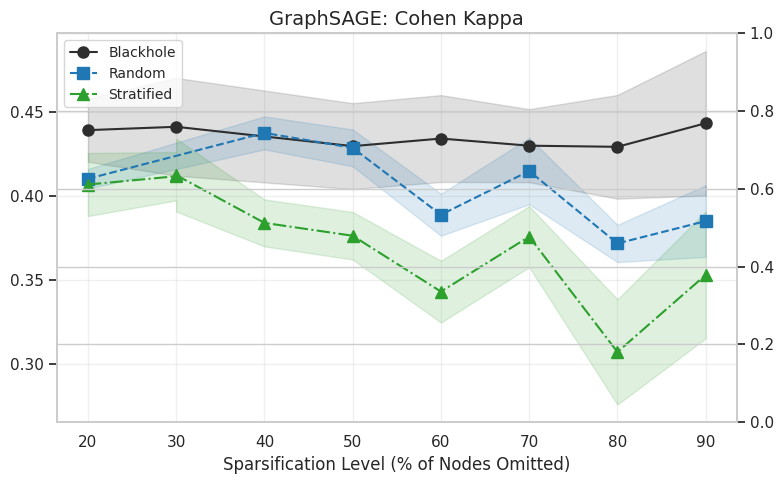

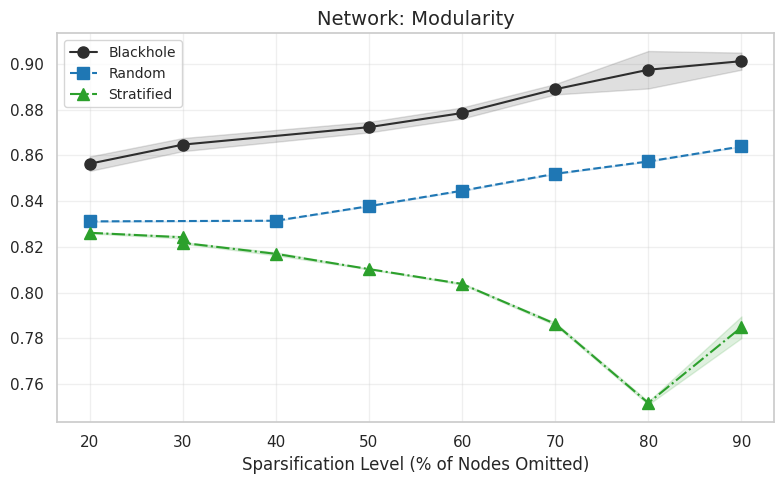

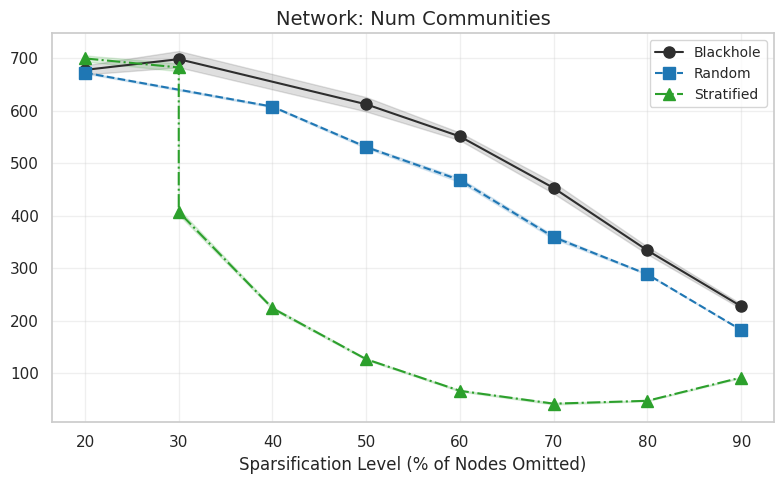

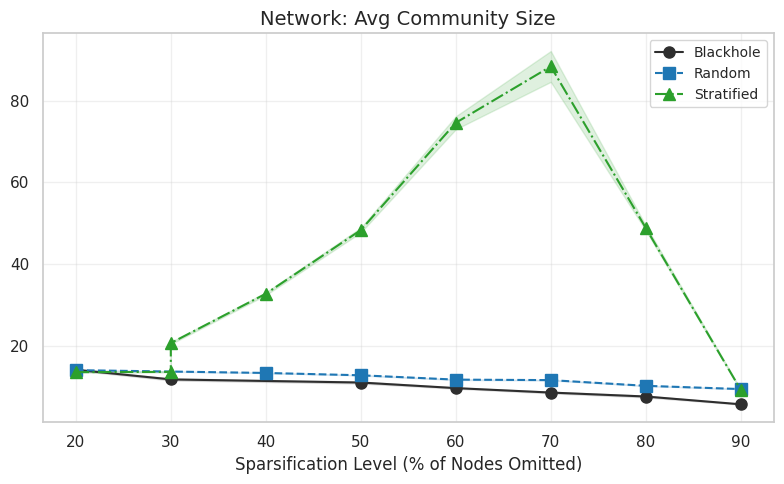

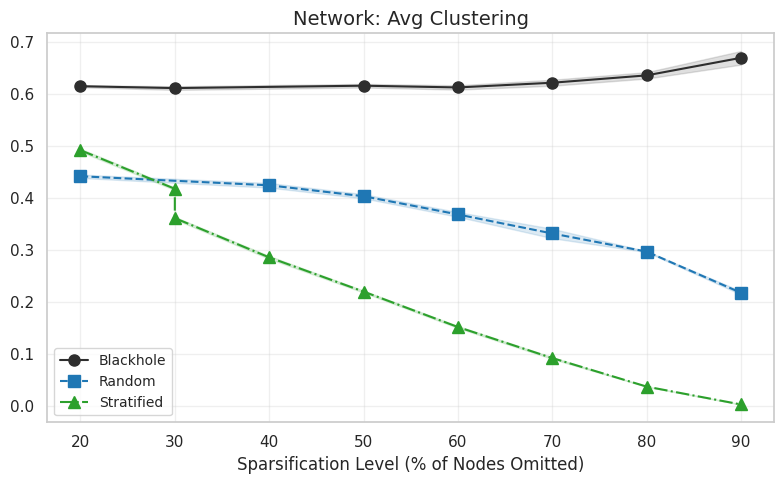

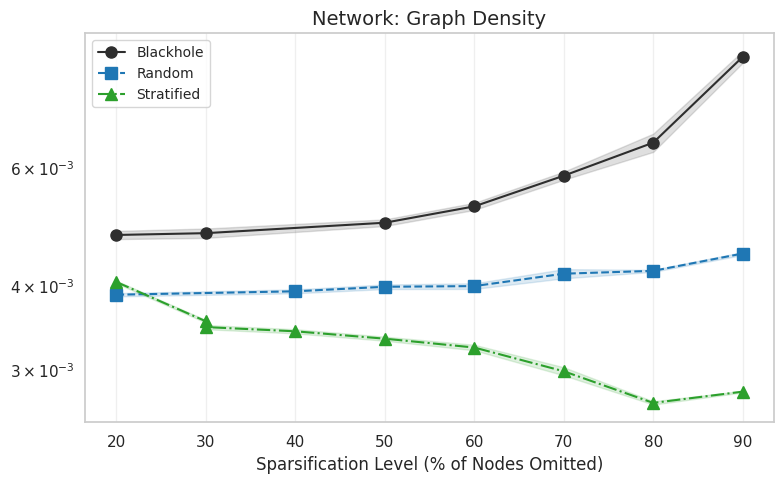

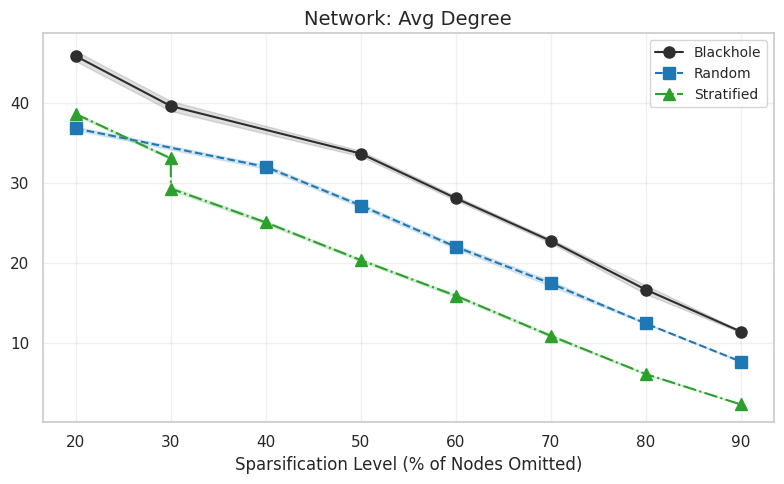

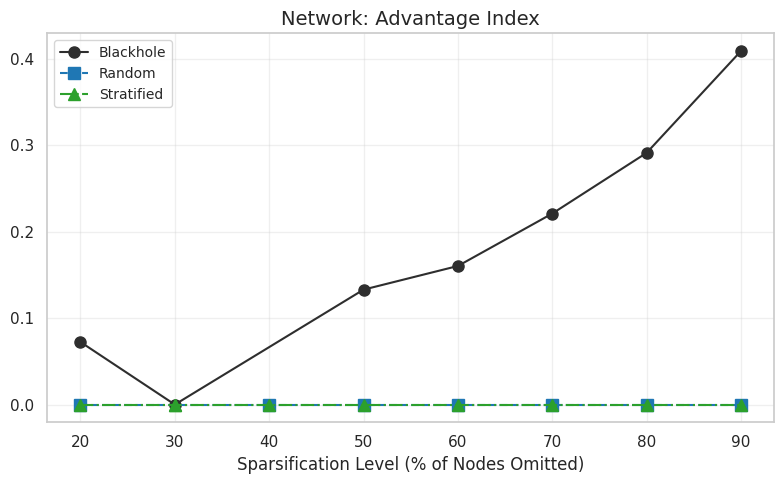

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                                Accuracy_Mean                      \
Model                                     GAT       GCN GraphSAGE   
Sparsification_Level Method                                         
20.0                 blackhole       0.631020  0.532491  0.600902   
                     random          0.615426  0.528694  0.581124   
                     stratified      0.609621  0.555617  0.578112   
30.0                 blackhole       0.619166  0.561877  0.603096   
                     stratified      0.605453  0.546449  0.580606   
40.0                 random          0.582293  0.627644  0.603491   
                     stratified      0.545236  0.509538  0.549789   
50.0                 blackhole       0.615319  0.553098  0.591615   
                     random          0.585939  0.617840  0.595118   
                     stratified      0.544942  0.501551  0.537904   
60.0                 blackhole       0.599861  0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

output_dir = 'plots_Comparison'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/aggregated_results3.csv')

# Calculate sparsification level (% of nodes omitted) and round to nearest 10%
df['Sparsification_Level'] = np.round((100 - df['Percent_Nodes_Retained_Mean']) / 10) * 10

# Filter data to include only Sparsification_Level from 20 to 90
df = df[df['Sparsification_Level'].isin([20, 30, 40, 50, 60, 70, 80, 90])]

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Extract baseline accuracy at Threshold == 0 for each model (using blackhole method)
baseline_acc = df[(df['Threshold'] == 0) & (df['Method'] == 'blackhole')][['Model', 'Accuracy_Mean']].drop_duplicates()
baseline_acc_dict = dict(zip(baseline_acc['Model'], baseline_acc['Accuracy_Mean']))

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    # Baseline values at min Sparsification_Level (max retention) for normalization
    min_percent = df['Sparsification_Level'].min()
    baseline = df[df['Sparsification_Level'] == min_percent].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_Mean': 0.4, 'Modularity_Mean': 0.3, 'Graph_Density_Mean': 0.3}
    df['Advantage_Index'] = 0.0

    # Check available methods in baseline
    available_methods = baseline.index.tolist()
    required_methods = ['blackhole', 'random', 'stratified']
    missing_methods = [m for m in required_methods if m not in available_methods]
    if missing_methods:
        print(f"Warning: Methods {missing_methods} not found in baseline at Sparsification_Level = {min_percent}%. Using overall mean for these methods.")
        # Use overall mean for missing methods
        overall_means = df.groupby('Method').mean(numeric_only=True)
        for method in missing_methods:
            baseline.loc[method] = overall_means.loc[method]

    for percent in df['Sparsification_Level'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Sparsification_Level'] == percent) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                rand_data = subset[subset['Method'] == 'random']
                strat_data = subset[subset['Method'] == 'stratified']

                if not (bh_data.empty or rand_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    rand_vals = rand_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_rand = baseline.loc['random', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]

                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        rand_val = rand_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        base_rand_val = base_rand[metric]
                        base_strat_val = base_strat[metric]

                        # Normalize differences
                        norm_bh_rand = (bh_val - rand_val) / base_bh_val if base_bh_val != 0 else (bh_val - rand_val)
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        # Average normalized advantage
                        metric_advantage = (norm_bh_rand + norm_bh_strat) / 2
                        advantage += weights[metric] * metric_advantage

                    df.loc[(df['Sparsification_Level'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_SEM'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_SEM')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std'),
    ('Advantage_Index', None)  # No SEM for derived index
]

# Models and sparsification level values
models = df['Model'].unique()
percent_values = sorted(df['Sparsification_Level'].unique())

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'random', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Sparsification_Level')
        if not method_data.empty:
            ax.plot(method_data['Sparsification_Level'], method_data[metric],
                    label=f'{method.title()}',
                    color=method_colors[method], linestyle=method_styles[method],
                    marker=method_markers[method], markersize=8)
            if std_metric:
                ax.fill_between(method_data['Sparsification_Level'],
                                method_data[metric] - method_data[std_metric],
                                method_data[metric] + method_data[std_metric],
                                alpha=0.15, color=method_colors[method])

    # Add baseline Accuracy at Threshold == 0 on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        model = title_prefix  # title_prefix is the model name (e.g., GAT, GCN)
        if model in baseline_acc_dict:
            baseline_value = baseline_acc_dict[model]
            ax2.axhline(y=baseline_value, color='purple', linestyle=':', label='Baseline Accuracy (BH, Threshold=0)', alpha=0.7)
            ax2.set_ylabel('Baseline Accuracy', fontsize=label_fontsize, color='purple')
            ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for percent in percent_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Sparsification_Level'] == percent)]
            rand_data = subset[(subset['Method'] == 'random') & (subset['Sparsification_Level'] == percent)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Sparsification_Level'] == percent)]
            if not (bh_data.empty or rand_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
                rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
                if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
                   is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(percent, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Sparsification Level (% of Nodes Omitted)', fontsize=label_fontsize)
    ax.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save and show plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for percent in percent_values:
    for model in models:
        bh_data = df[(df['Sparsification_Level'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Sparsification_Level'] == percent) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Sparsification_Level'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            rand_acc = rand_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, percent, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, percent, model, bh_acc, strat_acc))

# Find maximum and minimum distances
if distances_bh_random:
    max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
    min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
else:
    max_dist_bh_random = (0, 0, 'N/A', 0, 0)
    min_dist_bh_random = (0, 0, 'N/A', 0, 0)
if distances_bh_stratified:
    max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
    min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])
else:
    max_dist_bh_stratified = (0, 0, 'N/A', 0, 0)
    min_dist_bh_stratified = (0, 0, 'N/A', 0, 0)

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Sparsification_Level', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_SEM', 'Cohen_Kappa_Mean', 'Cohen_Kappa_SEM'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Sparsification_Level', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)


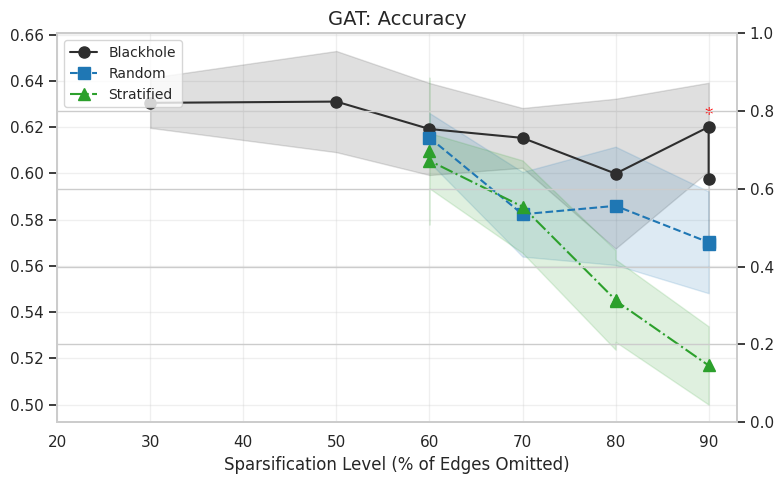

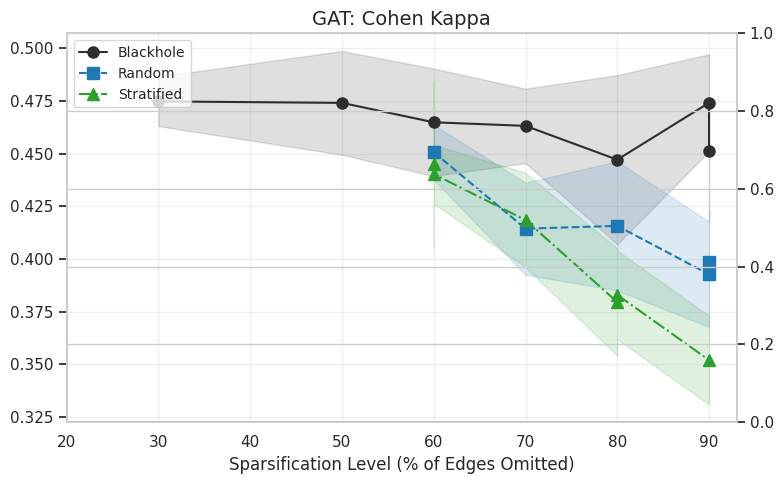

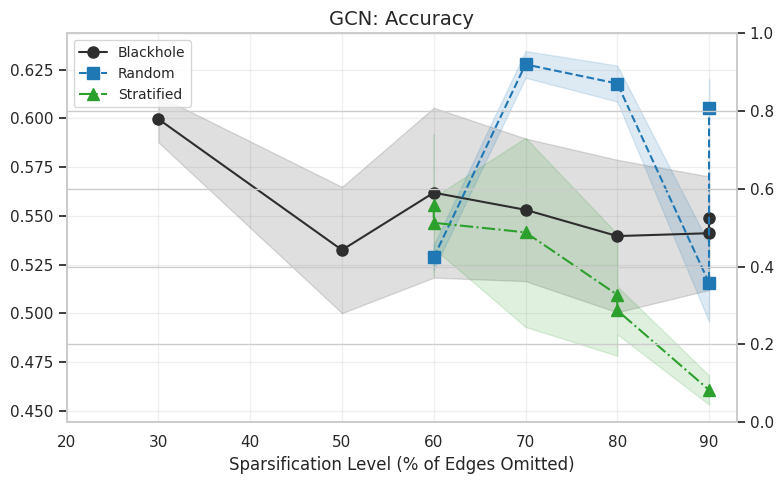

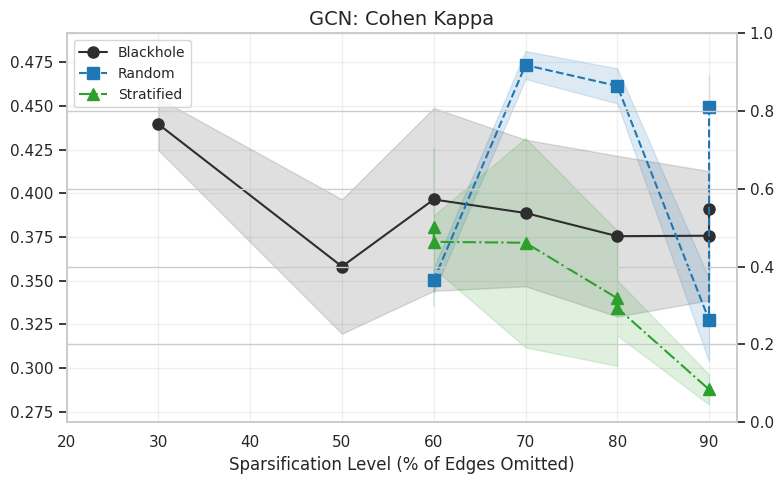

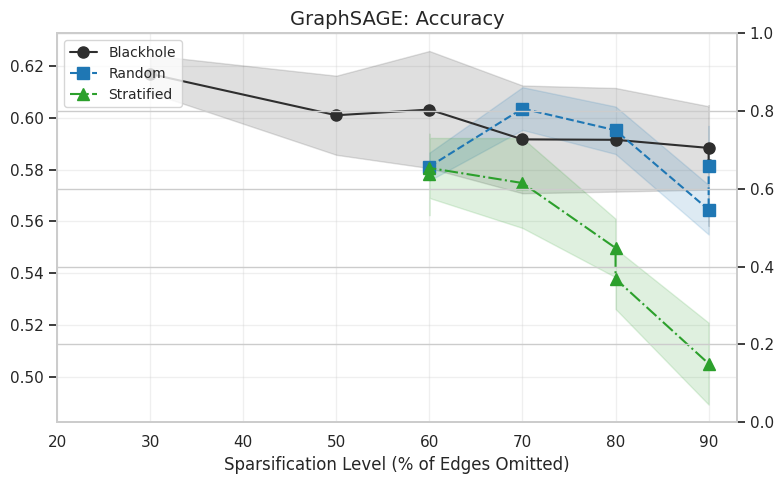

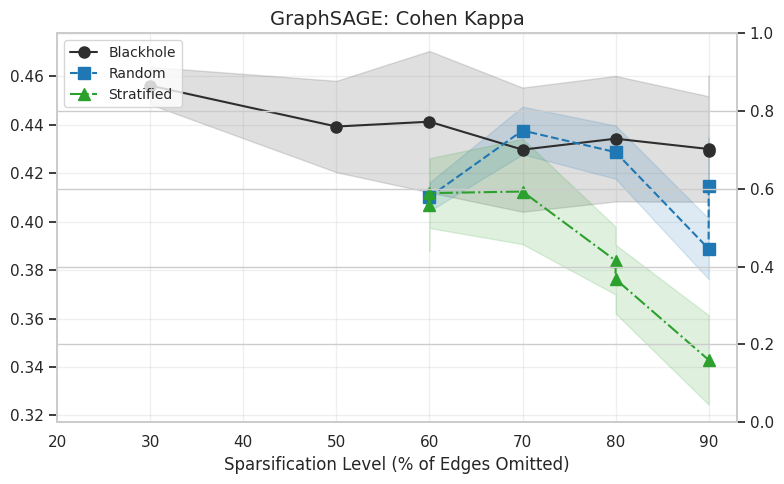

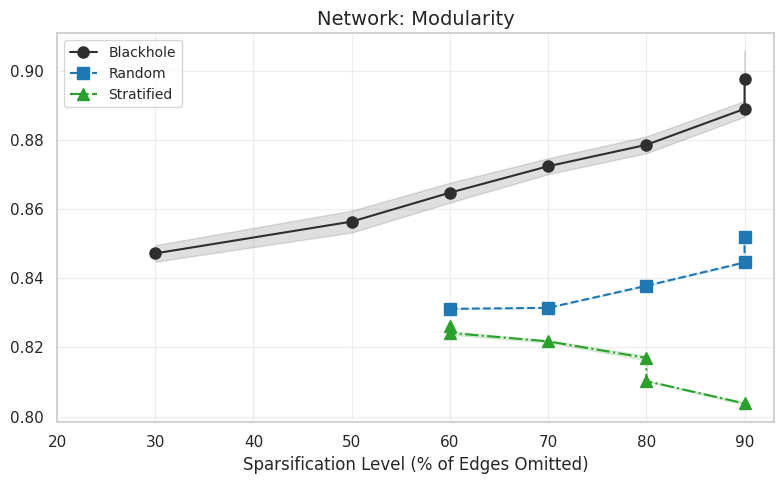

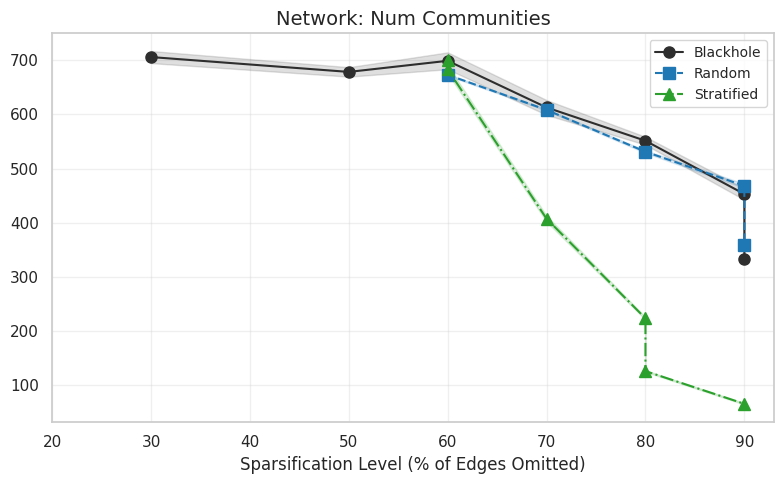

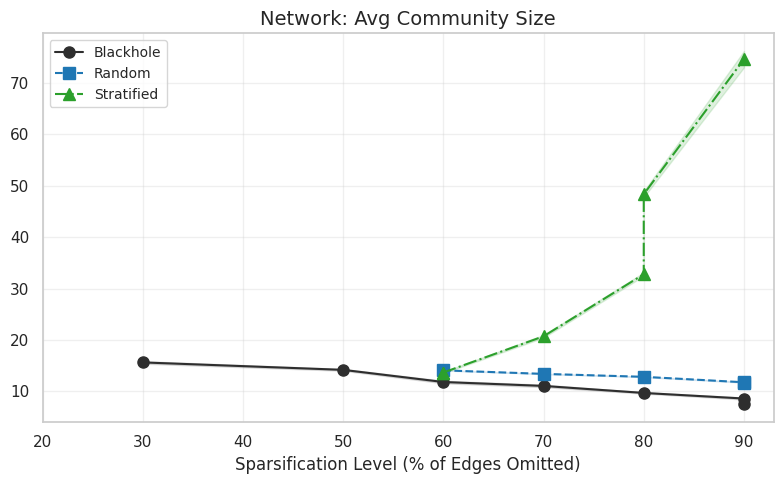

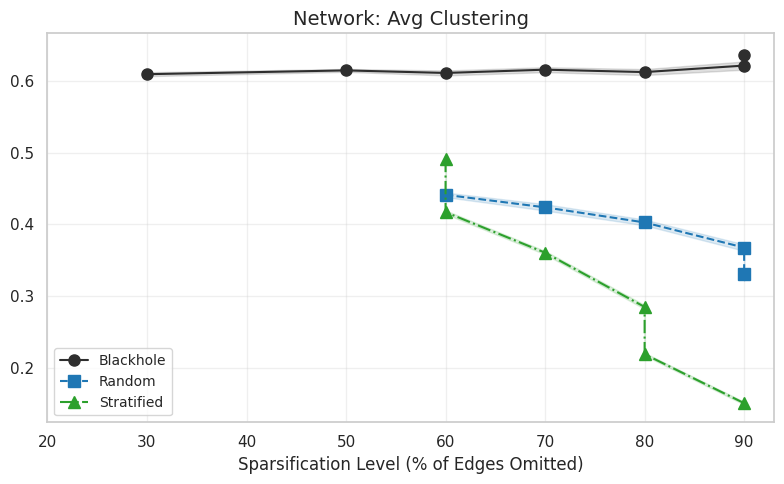

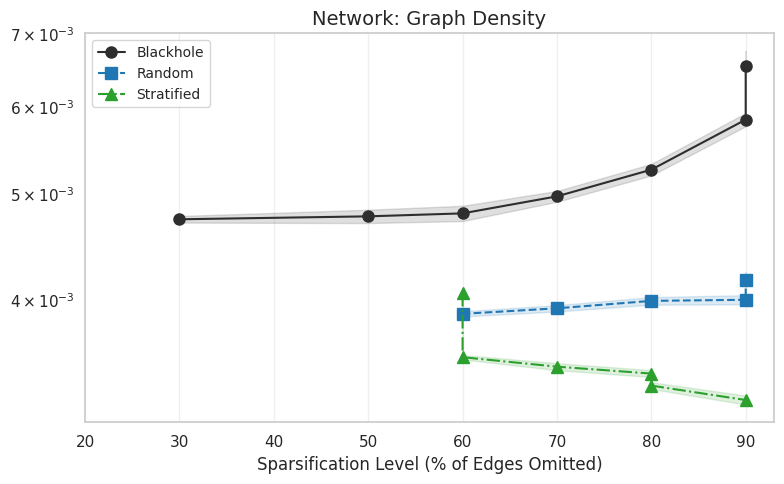

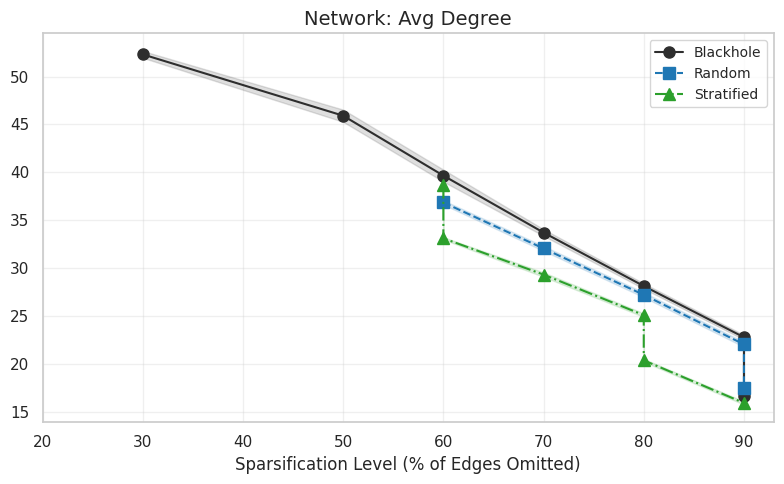

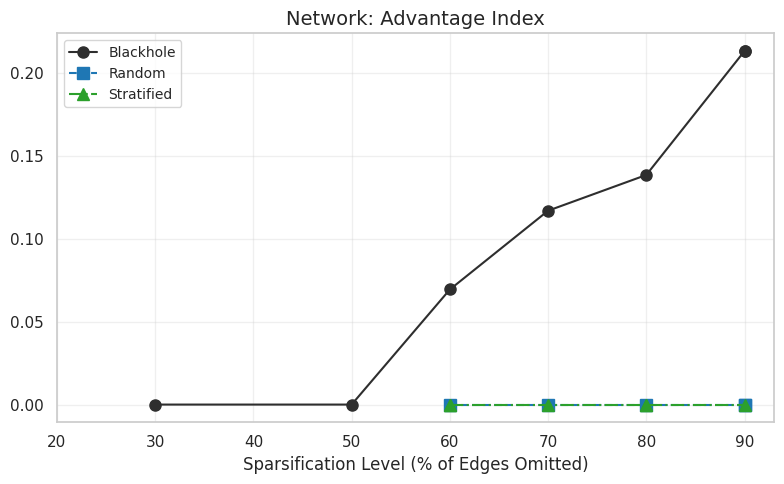

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                                      Accuracy_Mean                      \
Model                                           GAT       GCN GraphSAGE   
Sparsification_Level_Edges Method                                         
30.0                       blackhole       0.630473  0.599588  0.616825   
50.0                       blackhole       0.631020  0.532491  0.600902   
60.0                       blackhole       0.619166  0.561877  0.603096   
                           random          0.615426  0.528694  0.581124   
                           stratified      0.609621  0.555617  0.578112   
70.0                       blackhole       0.615319  0.553098  0.591615   
                           random          0.582293  0.627644  0.603491   
                           stratified      0.585581  0.541551  0.574800   
80.0                       blackhole       0.599861  0.539639  0.591454   
                           random          0.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

output_dir = 'plots_Comparison'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/aggregated_results3.csv')

# Calculate sparsification level (% of edges omitted) and round to nearest 10%
# Note: Assuming 'Percent_Edges_Retained_Mean' exists in the dataset. If not, replace with appropriate column or use Graph_Density_Mean as a proxy.
if 'Percent_Edges_Retained_Mean' in df.columns:
    df['Sparsification_Level_Edges'] = np.round((100 - df['Percent_Edges_Retained_Mean']) / 10) * 10
else:
    print("Warning: 'Percent_Edges_Retained_Mean' not found in dataset. Using Graph_Density_Mean as a proxy.")
    # Fallback: Normalize Graph_Density_Mean relative to baseline (Threshold == 0)
    baseline_density = df[df['Threshold'] == 0].groupby('Model')['Graph_Density_Mean'].mean()
    df['Sparsification_Level_Edges'] = df.apply(
        lambda row: np.round((1 - row['Graph_Density_Mean'] / baseline_density[row['Model']]) * 100 / 10) * 10
        if row['Model'] in baseline_density else 0, axis=1)

# Filter data to include only Sparsification_Level_Edges from 20 to 90
df = df[df['Sparsification_Level_Edges'].isin([20, 30, 40, 50, 60, 70, 80, 90])]

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Extract baseline accuracy at Threshold == 0 for each model (using blackhole method)
baseline_acc = df[(df['Threshold'] == 0) & (df['Method'] == 'blackhole')][['Model', 'Accuracy_Mean']].drop_duplicates()
baseline_acc_dict = dict(zip(baseline_acc['Model'], baseline_acc['Accuracy_Mean']))

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    # Baseline values at min Sparsification_Level_Edges (max edge retention) for normalization
    min_percent = df['Sparsification_Level_Edges'].min()
    baseline = df[df['Sparsification_Level_Edges'] == min_percent].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_Mean': 0.4, 'Modularity_Mean': 0.3, 'Graph_Density_Mean': 0.3}
    df['Advantage_Index'] = 0.0

    # Check available methods in baseline
    available_methods = baseline.index.tolist()
    required_methods = ['blackhole', 'random', 'stratified']
    missing_methods = [m for m in required_methods if m not in available_methods]
    if missing_methods:
        print(f"Warning: Methods {missing_methods} not found in baseline at Sparsification_Level_Edges = {min_percent}%. Using overall mean for these methods.")
        # Use overall mean for missing methods
        overall_means = df.groupby('Method').mean(numeric_only=True)
        for method in missing_methods:
            baseline.loc[method] = overall_means.loc[method]

    for percent in df['Sparsification_Level_Edges'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Sparsification_Level_Edges'] == percent) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                rand_data = subset[subset['Method'] == 'random']
                strat_data = subset[subset['Method'] == 'stratified']

                if not (bh_data.empty or rand_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    rand_vals = rand_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_rand = baseline.loc['random', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]

                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        rand_val = rand_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        base_rand_val = base_rand[metric]
                        base_strat_val = base_strat[metric]

                        # Normalize differences
                        norm_bh_rand = (bh_val - rand_val) / base_bh_val if base_bh_val != 0 else (bh_val - rand_val)
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        # Average normalized advantage
                        metric_advantage = (norm_bh_rand + norm_bh_strat) / 2
                        advantage += weights[metric] * metric_advantage

                    df.loc[(df['Sparsification_Level_Edges'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_SEM'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_SEM')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std'),
    ('Advantage_Index', None)  # No SEM for derived index
]

# Models and sparsification level values
models = df['Model'].unique()
percent_values = sorted(df['Sparsification_Level_Edges'].unique())

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] else None

    # Plot data for each method
    methods = ['blackhole', 'random', 'stratified']
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Sparsification_Level_Edges')
        if not method_data.empty:
            ax.plot(method_data['Sparsification_Level_Edges'], method_data[metric],
                    label=f'{method.title()}',
                    color=method_colors[method], linestyle=method_styles[method],
                    marker=method_markers[method], markersize=8)
            if std_metric:
                ax.fill_between(method_data['Sparsification_Level_Edges'],
                                method_data[metric] - method_data[std_metric],
                                method_data[metric] + method_data[std_metric],
                                alpha=0.15, color=method_colors[method])

    # Add baseline Accuracy at Threshold == 0 on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
        model = title_prefix  # title_prefix is the model name (e.g., GAT, GCN)
        if model in baseline_acc_dict:
            baseline_value = baseline_acc_dict[model]
            ax2.axhline(y=baseline_value, color='purple', linestyle=':', label='Baseline Accuracy (BH, Threshold=0)', alpha=0.7)
            ax2.set_ylabel('Baseline Accuracy', fontsize=label_fontsize, color='purple')
            ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for percent in percent_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Sparsification_Level_Edges'] == percent)]
            rand_data = subset[(subset['Method'] == 'random') & (subset['Sparsification_Level_Edges'] == percent)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Sparsification_Level_Edges'] == percent)]
            if not (bh_data.empty or rand_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
                rand_acc, rand_sem = rand_data['Accuracy_Mean'].values[0], rand_data['Accuracy_SEM'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
                if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
                   is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(percent, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Sparsification Level (% of Edges Omitted)', fontsize=label_fontsize)
    ax.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_Mean':
        ax.set_yscale('log')

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    # Save and show plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for percent in percent_values:
    for model in models:
        bh_data = df[(df['Sparsification_Level_Edges'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Sparsification_Level_Edges'] == percent) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Sparsification_Level_Edges'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            rand_acc = rand_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, percent, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, percent, model, bh_acc, strat_acc))

# Find maximum and minimum distances
if distances_bh_random:
    max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
    min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
else:
    max_dist_bh_random = (0, 0, 'N/A', 0, 0)
    min_dist_bh_random = (0, 0, 'N/A', 0, 0)
if distances_bh_stratified:
    max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
    min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])
else:
    max_dist_bh_stratified = (0, 0, 'N/A', 0, 0)
    min_dist_bh_stratified = (0, 0, 'N/A', 0, 0)

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Sparsification_Level_Edges', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_SEM', 'Cohen_Kappa_Mean', 'Cohen_Kappa_SEM'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Sparsification_Level_Edges', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)


First 5 rows of CSV for diagnosis:
   Threshold     Method      Model  Accuracy_Mean  Accuracy_Std  \
0        0.0  blackhole        GAT       0.610824           NaN   
1        0.0  blackhole        GCN       0.617986           NaN   
2        0.0  blackhole  GraphSAGE       0.612813           NaN   
3        0.1  blackhole        GAT       0.630473      0.010814   
4        0.1  blackhole        GCN       0.599588      0.011939   

   Cohen_Kappa_Mean  Cohen_Kappa_Std  Num_Edges_Mean  Num_Edges_Std  \
0          0.449469              NaN        414650.0            NaN   
1          0.460358              NaN        414650.0            NaN   
2          0.452886              NaN        414650.0            NaN   
3          0.474705         0.011726        288575.2    1945.989825   
4          0.439569         0.014961        288575.2    1945.989825   

   Num_Nodes_Mean  ...  Avg_Degree_Mean  Avg_Degree_Std  Nodes_Removed_Mean  \
0         12561.0  ...        66.021814             NaN 

<ipython-input-11-4606a907e4d0>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
<ipython-input-11-4606a907e4d0>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)


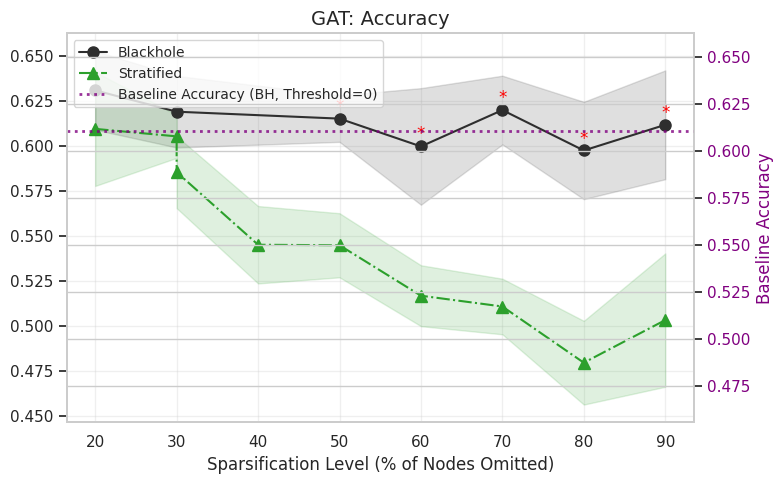

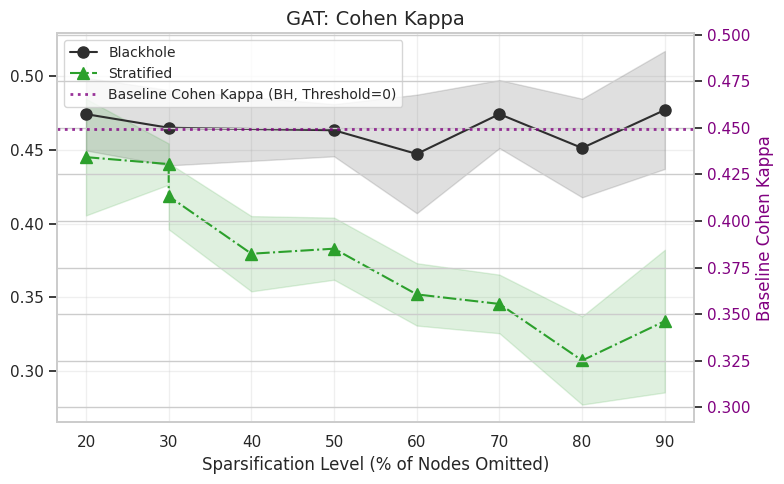

Plotting GCN baseline for Accuracy_Mean: 0.6179864703541583, y-axis range: [0.40650007318607384, 0.6488857938718663]


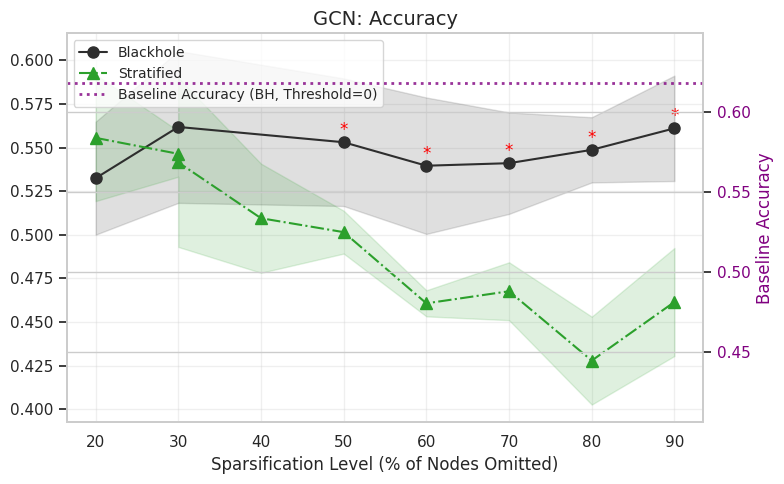

Plotting GCN baseline for Cohen_Kappa_Mean: 0.4603580791496292, y-axis range: [0.2313969999152942, 0.48337598310711066]


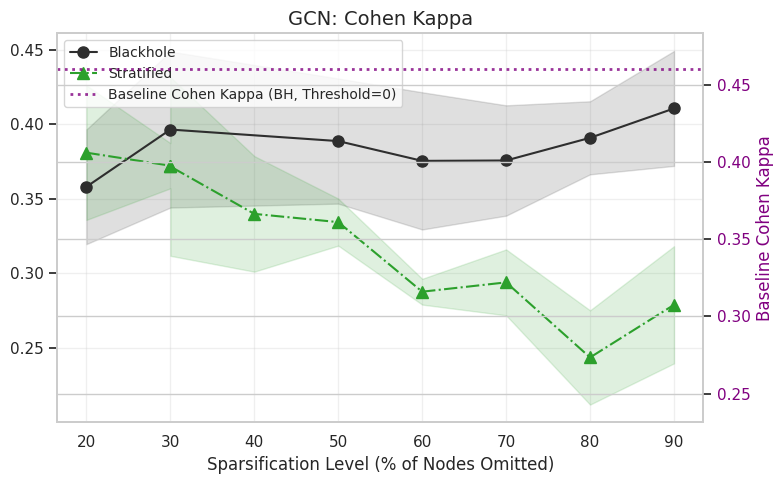

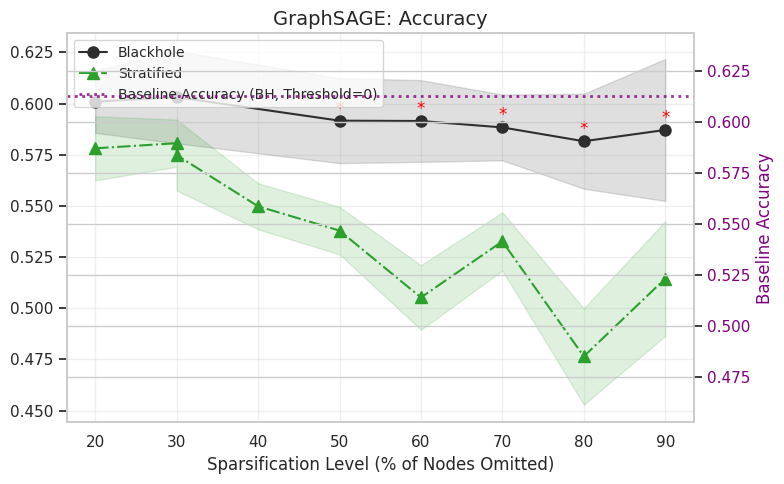

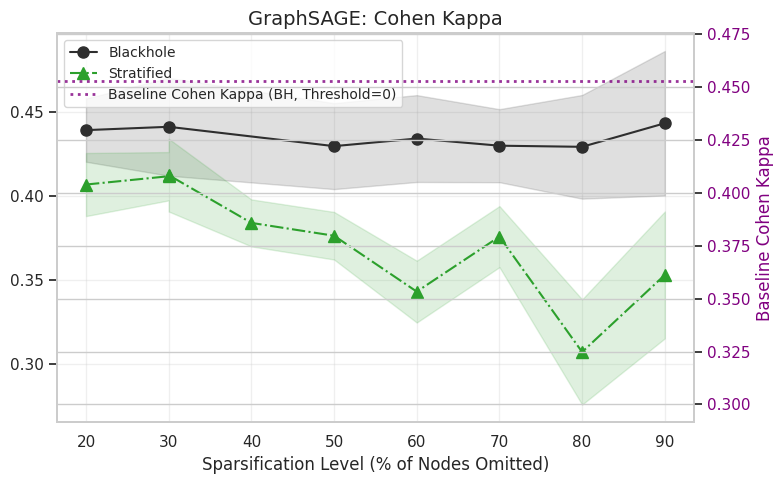

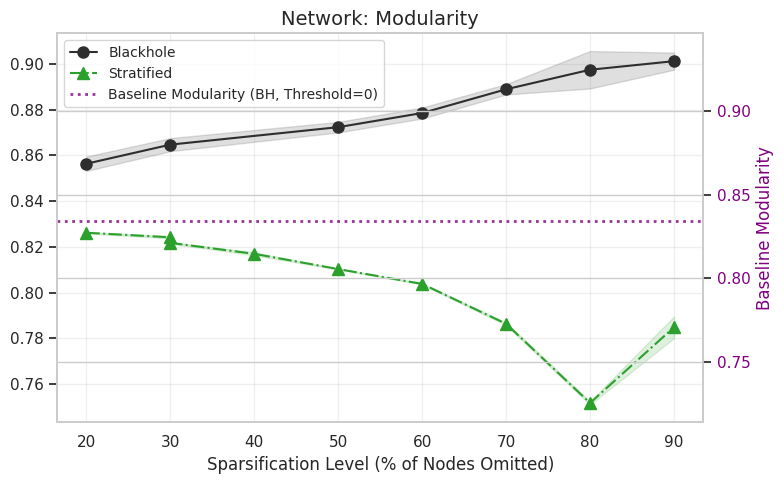

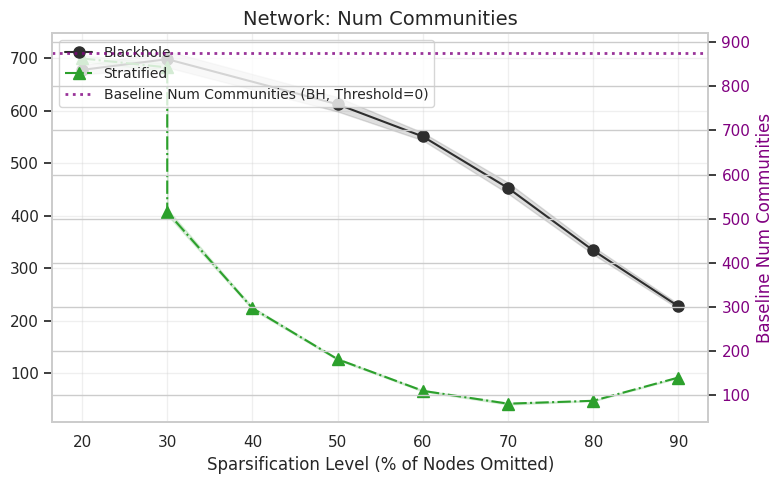

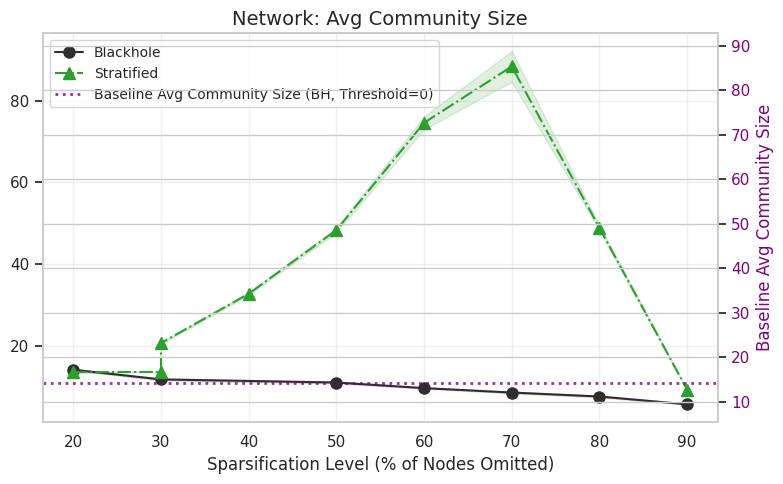

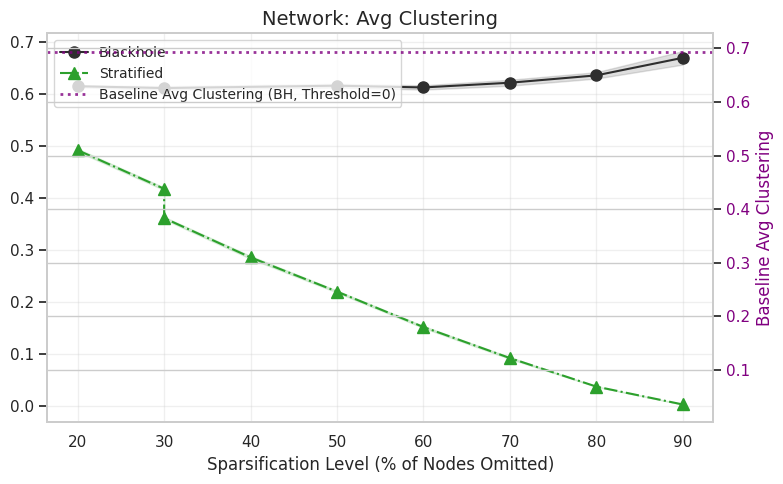

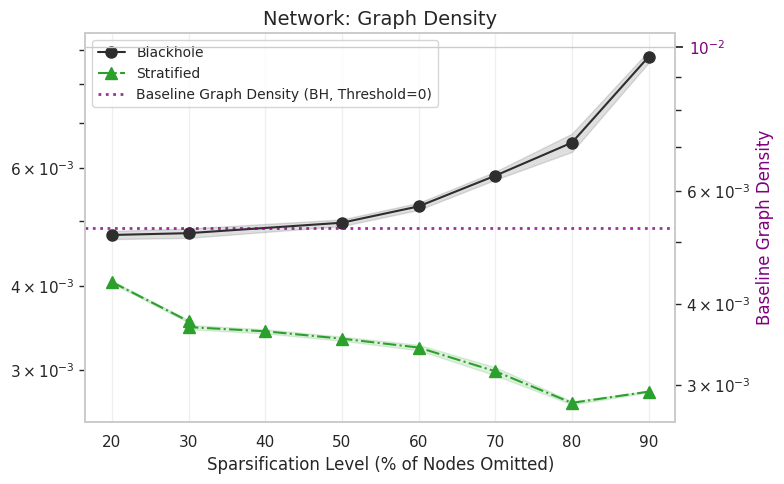

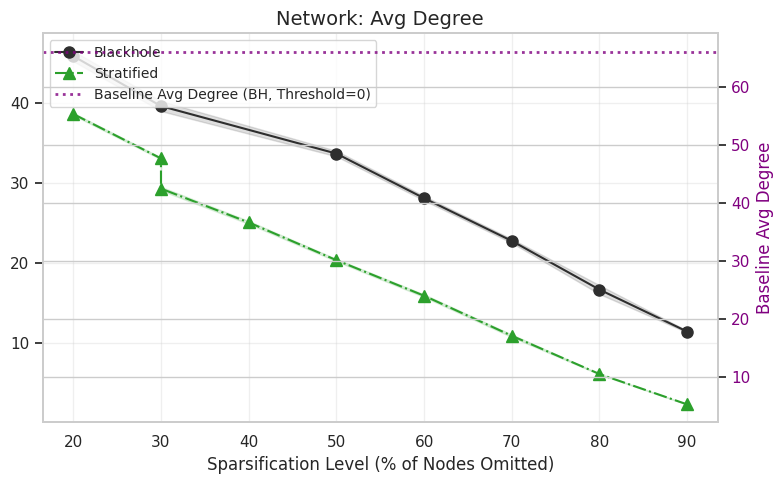

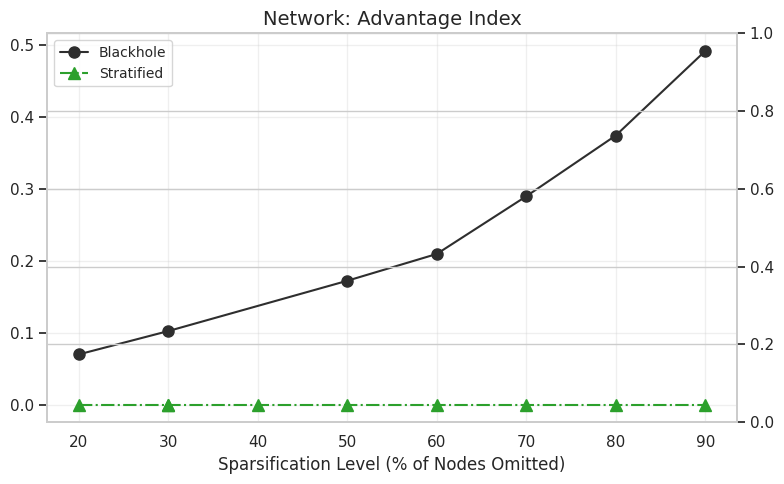

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                                Accuracy_Mean                      \
Model                                     GAT       GCN GraphSAGE   
Sparsification_Level Method                                         
20.0                 blackhole       0.631020  0.532491  0.600902   
                     random          0.615426  0.528694  0.581124   
                     stratified      0.609621  0.555617  0.578112   
30.0                 blackhole       0.619166  0.561877  0.603096   
                     stratified      0.605453  0.546449  0.580606   
40.0                 random          0.582293  0.627644  0.603491   
                     stratified      0.545236  0.509538  0.549789   
50.0                 blackhole       0.615319  0.553098  0.591615   
                     random          0.585939  0.617840  0.595118   
                     stratified      0.544942  0.501551  0.537904   
60.0                 blackhole       0.599861  0

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'stratified': '^'
}

output_dir = 'plots_Comparison'
os.makedirs(output_dir, exist_ok=True)

# Load data
try:
    df = pd.read_csv('https://raw.githubusercontent.com/MehrdadJalali-AI/BlackHole/main/aggregated_results3.csv')
    print("First 5 rows of CSV for diagnosis:")
    print(df.head())
    print("\nCSV Column Names and Data Types:")
    print(df.dtypes)
    print("\nUnique Threshold Values:")
    print(df['Threshold'].unique())
    print("\nUnique Method Values:")
    print(df['Method'].unique())
    print("\nUnique Model Values:")
    print(df['Model'].unique())
    print("\nRows with Threshold close to 0:")
    print(df[abs(df['Threshold']) < 1e-3][['Threshold', 'Method', 'Model', 'Accuracy_Mean', 'Cohen_Kappa_Mean']])
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

# Calculate sparsification level
df['Sparsification_Level'] = np.round((100 - df['Percent_Nodes_Retained_Mean']) / 10) * 10

# Extract baseline values BEFORE filtering
baseline_metrics = df[(abs(df['Threshold']) < 1e-6) & (df['Method'].str.lower() == 'blackhole')][
    ['Model', 'Accuracy_Mean', 'Cohen_Kappa_Mean', 'Modularity_Mean',
     'Num_Communities_Mean', 'Avg_Community_Size_Mean', 'Avg_Clustering_Mean',
     'Graph_Density_Mean', 'Avg_Degree_Mean']
].drop_duplicates()

# Debug: Print raw filtered baseline data
print("\nRaw Baseline Data (Threshold == 0, Method == blackhole):")
print(baseline_metrics)
print("\nCheck for GCN in baseline_metrics:")
print(baseline_metrics[baseline_metrics['Model'] == 'GCN'][['Model', 'Accuracy_Mean', 'Cohen_Kappa_Mean']])

# Check if baseline data is empty
if baseline_metrics.empty:
    print("Error: No baseline data found in CSV for Threshold == 0 and Method == blackhole. Cannot plot baselines.")
    baseline_dict = {}
    baseline_network_avg = {}
else:
    # Create baseline dictionary for model-specific performance metrics
    baseline_dict = {
        metric: baseline_metrics.set_index('Model')[metric].to_dict()
        for metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean', 'Modularity_Mean',
                       'Num_Communities_Mean', 'Avg_Community_Size_Mean',
                       'Avg_Clustering_Mean', 'Graph_Density_Mean', 'Avg_Degree_Mean']
    }
    # Compute average baseline for network metrics
    network_metrics_list = [
        'Modularity_Mean', 'Num_Communities_Mean', 'Avg_Community_Size_Mean',
        'Avg_Clustering_Mean', 'Graph_Density_Mean', 'Avg_Degree_Mean'
    ]
    baseline_network_avg = {
        metric: baseline_metrics[metric].mean() for metric in network_metrics_list
        if metric in baseline_metrics and not baseline_metrics[metric].isna().all()
    }

# Now apply filtering for rest of the analysis
df = df[df['Sparsification_Level'].isin([20, 30, 40, 50, 60, 70, 80, 90])]

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_SEM'] = df['Accuracy_Std'] / np.sqrt(1)
df['Cohen_Kappa_SEM'] = df['Cohen_Kappa_Std'] / np.sqrt(1)

# Debug: Print baseline values to verify
print("\nModel-Specific Baseline Values (Threshold == 0, blackhole method):")
for metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean']:
    if baseline_dict and metric in baseline_dict:
        print(f"{metric}: {baseline_dict[metric]}")
        if 'GCN' in baseline_dict[metric]:
            print(f"GCN-specific value for {metric}: {baseline_dict[metric]['GCN']}")
        else:
            print(f"Warning: GCN not found in baseline_dict for {metric}")
    else:
        print(f"Error: {metric} not found in baseline_dict")
print("\nAverage Baseline Values for Network Metrics (Threshold == 0, blackhole method):")
for metric in network_metrics_list:
    if baseline_network_avg and metric in baseline_network_avg:
        print(f"{metric}: {baseline_network_avg[metric]}")
    else:
        print(f"Error: {metric} not found in baseline_network_avg")

# Compute Advantage Index
def calculate_advantage_index(df):
    df = df.copy()
    min_percent = df['Sparsification_Level'].min()
    baseline = df[df['Sparsification_Level'] == min_percent].groupby('Method').mean(numeric_only=True)
    weights = {'Accuracy_Mean': 0.4, 'Modularity_Mean': 0.3, 'Graph_Density_Mean': 0.3}
    df['Advantage_Index'] = 0.0

    available_methods = baseline.index.tolist()
    required_methods = ['blackhole', 'stratified']
    missing_methods = [m for m in required_methods if m not in available_methods]
    if missing_methods:
        print(f"Warning: Methods {missing_methods} not found in baseline at Sparsification_Level = {min_percent}%. Using overall mean for these methods.")
        overall_means = df.groupby('Method').mean(numeric_only=True)
        for method in missing_methods:
            baseline.loc[method] = overall_means.loc[method]

    for percent in df['Sparsification_Level'].unique():
        for model in df['Model'].unique():
            subset = df[(df['Sparsification_Level'] == percent) & (df['Model'] == model)]
            if not subset.empty:
                bh_data = subset[subset['Method'] == 'blackhole']
                strat_data = subset[subset['Method'] == 'stratified']
                if not (bh_data.empty or strat_data.empty):
                    bh_vals = bh_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    strat_vals = strat_data[['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']].iloc[0]
                    base_bh = baseline.loc['blackhole', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    base_strat = baseline.loc['stratified', ['Accuracy_Mean', 'Modularity_Mean', 'Graph_Density_Mean']]
                    advantage = 0.0
                    for metric in weights.keys():
                        bh_val = bh_vals[metric]
                        strat_val = strat_vals[metric]
                        base_bh_val = base_bh[metric]
                        norm_bh_strat = (bh_val - strat_val) / base_bh_val if base_bh_val != 0 else (bh_val - strat_val)
                        metric_advantage = norm_bh_strat
                        advantage += weights[metric] * metric_advantage
                    df.loc[(df['Sparsification_Level'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model), 'Advantage_Index'] = advantage
    return df

df = calculate_advantage_index(df)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_Mean', 'Accuracy_SEM'),
    ('Cohen_Kappa_Mean', 'Cohen_Kappa_SEM')
]
network_metrics = [
    ('Modularity_Mean', 'Modularity_Std'),
    ('Num_Communities_Mean', 'Num_Communities_Std'),
    ('Avg_Community_Size_Mean', 'Avg_Community_Size_Std'),
    ('Avg_Clustering_Mean', 'Avg_Clustering_Std'),
    ('Graph_Density_Mean', 'Graph_Density_Std'),
    ('Avg_Degree_Mean', 'Avg_Degree_Std'),
    ('Advantage_Index', None)
]

# Models and sparsification level values
models = df['Model'].unique()
percent_values = sorted(df['Sparsification_Level'].unique())

# Font sizes
label_fontsize = 12
tick_fontsize = 11
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for combined comparisons
def plot_comparison(subset, metric, std_metric, title_prefix):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx()  # Secondary y-axis for baseline

    # Plot data for each method
    methods = ['blackhole', 'stratified']
    y_min, y_max = float('inf'), float('-inf')
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Sparsification_Level')
        if not method_data.empty:
            ax.plot(method_data['Sparsification_Level'], method_data[metric],
                    label=f'{method.title()}',
                    color=method_colors[method], linestyle=method_styles[method],
                    marker=method_markers[method], markersize=8)
            if std_metric:
                ax.fill_between(method_data['Sparsification_Level'],
                                method_data[metric] - method_data[std_metric],
                                method_data[metric] + method_data[std_metric],
                                alpha=0.15, color=method_colors[method])
            y_min = min(y_min, method_data[metric].min())
            y_max = max(y_max, method_data[metric].max())

    # Add baseline for the metric at Threshold == 0 on secondary y-axis
    model = title_prefix if title_prefix in models else 'GAT'
    baseline_value = None
    if metric in ['Accuracy_Mean', 'Cohen_Kappa_Mean'] and baseline_dict and metric in baseline_dict and model in baseline_dict[metric]:
        baseline_value = baseline_dict[metric][model]
    elif metric in network_metrics_list and baseline_network_avg and metric in baseline_network_avg:
        baseline_value = baseline_network_avg[metric]

    if baseline_value is not None:
        ax2.axhline(y=baseline_value, color='purple', linestyle=':', linewidth=2,
                    label=f'Baseline {metric.replace("_Mean", "").replace("_", " ").title()} (BH, Threshold=0)', alpha=0.8)
        ax2.set_ylabel(f'Baseline {metric.replace("_Mean", "").replace("_", " ").title()}', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')
        # Adjust y-axis limits to include baseline value
        y_min = min(y_min, baseline_value)
        y_max = max(y_max, baseline_value)
        if metric == 'Graph_Density_Mean':
            ax.set_yscale('log')
            ax2.set_yscale('log')
            ax2.set_ylim(max(y_min * 0.5, baseline_value * 0.5), min(y_max * 2, baseline_value * 2))
        else:
            ax2.set_ylim(y_min * 0.95, y_max * 1.05)
        if model == 'GCN':
            print(f"Plotting GCN baseline for {metric}: {baseline_value}, y-axis range: [{y_min * 0.95}, {y_max * 1.05}]")
    else:
        print(f"Warning: No baseline value found for {metric} in model {model}")

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_Mean':
        for percent in percent_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Sparsification_Level'] == percent)]
            strat_data = subset[(subset['Method'] == 'stratified') & (subset['Sparsification_Level'] == percent)]
            if not (bh_data.empty or strat_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_Mean'].values[0], bh_data['Accuracy_SEM'].values[0]
                strat_acc, strat_sem = strat_data['Accuracy_Mean'].values[0], strat_data['Accuracy_SEM'].values[0]
                if is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                    ax.annotate('*', xy=(percent, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_Mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name}', fontsize=title_fontsize)
    ax.set_xlabel('Sparsification Level (% of Nodes Omitted)', fontsize=label_fontsize)
    ax.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')

    # Save plot
    metric_safe = metric.replace('_', '-')
    filename = f'{title_prefix.lower()}-{metric_safe}'
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[df['Model'] == model]
    for metric, std_metric in performance_metrics:
        plot_comparison(subset, metric, std_metric, model)

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[df['Model'] == 'GAT']
for metric, std_metric in network_metrics:
    plot_comparison(subset, metric, std_metric, 'Network')

# Calculate maximum and minimum distances of BH Accuracy from Stratified
distances_bh_stratified = []
for percent in percent_values:
    for model in models:
        bh_data = df[(df['Sparsification_Level'] == percent) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        strat_data = df[(df['Sparsification_Level'] == percent) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_Mean'].values[0]
            strat_acc = strat_data['Accuracy_Mean'].values[0]
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_stratified.append((dist_bh_stratified, percent, model, bh_acc, strat_acc))

# Find maximum and minimum distances
if distances_bh_stratified:
    max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
    min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])
else:
    max_dist_bh_stratified = (0, 0, 'N/A', 0, 0)
    min_dist_bh_stratified = (0, 0, 'N/A', 0, 0)

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Sparsification_Level', 'Method'],
    columns='Model',
    values=['Accuracy_Mean', 'Accuracy_SEM', 'Cohen_Kappa_Mean', 'Cohen_Kappa_SEM'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Sparsification_Level', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)